In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/')
import ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from sklearn.manifold import TSNE
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from utils.data import preprocessing

# Variables


In [2]:
num_topics = 2
use_title = True
stemming = True
lemmatization = True
lib = "spacy"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Note
We also had ```gensim``` supported for preprocessing, but realized that even in their official docs, they make it a point that this should not be a use case! After having odd problems with their lemmatization routines (and ```pattern```), we just dropped it...

# Data loading and preparation

## load

In [4]:
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
data_df = pd.json_normalize(data['papers'])
corpus = data_df["abstract"]
if use_title:
    corpus = data_df["title"] + " " + corpus 


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess

In [5]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dropping 0 entries of corpus, due to nan ...


2it [00:00, 14.18it/s]

Starting tokenization ...


1261it [01:00, 20.86it/s]


In [6]:
dictionary = corpora.Dictionary(corpus["token"]) 
BoW_corpus = [dictionary.doc2bow(text) for text in corpus["token"]]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LSI

## TFIDF

In [8]:
lsi_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)# train model
lsi_tfidf[corpus_tfidf[1]]  # apply model to  document

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.22563006856395001), (1, -0.04065386737664447)]

## Bag of Words

In [9]:
lsi_bow = models.LsiModel(BoW_corpus, id2word=dictionary, num_topics=num_topics)
lsi_bow[BoW_corpus[1]]  # apply model to  document

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 10.014636582364723), (1, -1.6653247415719226)]

# LDA

## init

In [10]:
# LDA model training 
lda_model = models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Inspect

In [108]:
preprocessing_str = f"(Preprocessing with {lib}, Stemming = {stemming}, Lemmatization = {lemmatization})"

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
abstract_count = 0
for abstract in data_df["abstract"]:
    if abstract:
        abstract_count += 1

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
print("There are " + str(len(data_df["abstract"])) + f" Papers. {str(abstract_count)} of them have Abstracts.")

There are 1261 Papers. 1225 of them have Abstracts.


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Keywords

In [11]:
for keyword in data_df["keywords"]:
    print(keyword)

['metric learning', 'convex optimization', 'semi-definite programming', 'first-order methods', 'eigenvalue optimization', 'matrix factorization']
['feature selection', 'mutual information']
['active learning', 'selective sampling', 'model selection', 'classification']
['statistical learning theory', 'active learning', 'ranking', 'pairwise ranking']
['distributed computing', 'online learning', 'stochastic optimization', 'regret bounds']
['clustering', 'active clustering', 'k-median', 'approximation algorithms', 'approximation sta-     bility', 'clustering accuracy']
['classification with a reject option', 'perfect classification', 'selective classification', 'ac-     tive learning', 'selective sampling', 'disagreement coefficient', 'teaching dimension']
['global optimization', 'model selection', 'neural networks', 'deep learning']
['optical character recognition', 'probability bounding', 'document-specific modeling']
['sparsity', 'kernel', 'non-parametric', 'convex']
['low rank', 'Riema

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
print(f"The Dataset contains {len(data_df)} Papers")
count_keywords = 0
all_keywords = []
for keyword in data_df["keywords"]:
    if keyword and keyword[0]:
        count_keywords += 1
        all_keywords = all_keywords + keyword
print(f"{count_keywords} of them contain Keywords.")
print(f"There are {len(all_keywords)} Keywords. {len(set(all_keywords))} of them are unique.")


The Dataset contains 1261 Papers
1108 of them contain Keywords.
There are 4378 Keywords. 3139 of them are unique.


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Corpus

In [74]:
pprint.pprint(dictionary.token2id)#token -> tokenId.

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: '  ',
 1: '   ',
 2: '-pron-',
 3: '1988',
 4: '1996',
 5: '2005',
 6: 'addit',
 7: 'al',
 8: 'algorithm',
 9: 'approach',
 10: 'art',
 11: 'avenu',
 12: 'benchmark',
 13: 'challeng',
 14: 'characterist',
 15: 'competit',
 16: 'comput',
 17: 'context',
 18: 'converg',
 19: 'data',
 20: 'datum',
 21: 'design',
 22: 'develop',
 23: 'difficult',
 24: 'distanc',
 25: 'dml',
 26: 'effici',
 27: 'eig',
 28: 'eigenvalu',
 29: 'eigenvector',
 30: 'encourag',
 31: 'equival',
 32: 'establish',
 33: 'et',
 34: 'experi',
 35: 'face',
 36: 'formul',
 37: 'framework',
 38: 'inde',
 39: 'insight',
 40: 'introduc',
 41: 'iter',
 42: 'know',
 43: 'label',
 44: 'larg',
 45: 'learn',
 46: 'lewi',
 47: 'lfw',
 48: 'lmnn',
 49: 'mahalanobi',
 50: 'main',
 51: 'matrix',
 52: 'maxim',
 53: 'method',
 54: 'metric',
 55: 'minim',
 56: 'moreov',
 57: 'need',
 58: 'new',
 59: 'novel',
 60: 'onli',
 61: 'open',
 62: 'optim',
 63: 'order',
 64: 'overton',
 65: 'paper',
 66: 'perform',
 67: 'problem',
 68: 'pro

 1146: 'articl',
 1147: 'concav',
 1148: 'emerg',
 1149: 'multistag',
 1150: 'penal',
 1151: 'recurs',
 1152: 'theorem',
 1153: 'tool',
 1154: 'understand',
 1155: 'bodi',
 1156: 'conjug',
 1157: 'decid',
 1158: 'dualiti',
 1159: 'organ',
 1160: 'sophist',
 1161: 'cloud',
 1162: 'rare',
 1163: 'replac',
 1164: 'updat',
 1165: 'absent',
 1166: 'action',
 1167: 'admiss',
 1168: 'complementari',
 1169: 'compromis',
 1170: 'current',
 1171: 'environment',
 1172: 'feedback',
 1173: 'hybrid',
 1174: 'polici',
 1175: 'uncertainti',
 1176: 'whenev',
 1177: 'analys',
 1178: 'api',
 1179: 'cookbook',
 1180: 'de',
 1181: 'discret',
 1182: 'especi',
 1183: 'foster',
 1184: 'gpl',
 1185: 'jstac',
 1186: 'licens',
 1187: 'orient',
 1188: 'tailor',
 1189: 'chang',
 1190: 'clip',
 1191: 'coordin',
 1192: 'deal',
 1193: 'decent',
 1194: 'dynam',
 1195: 'enjoy',
 1196: 'frequenc',
 1197: 'l0',
 1198: 'scad',
 1199: 'shrinkag',
 1200: 'vari',
 1201: 'zero',
 1202: 'adjust',
 1203: 'care',
 1204: 'cdn',
 

 2145: 'predic',
 2146: 'tukey',
 2147: 'bit',
 2148: '1358',
 2149: '18',
 2150: '21',
 2151: '236',
 2152: '53',
 2153: 'aleph',
 2154: 'arithmet',
 2155: 'enumer',
 2156: 'exclud',
 2157: 'formula',
 2158: 'logic',
 2159: 'nrsampl',
 2160: 'overhead',
 2161: 'progol',
 2162: 'prune',
 2163: 'satisfact',
 2164: 'synthesi',
 2165: 'winner',
 2166: 'conform',
 2167: 'harmon',
 2168: 'harmoni',
 2169: 'sell',
 2170: 'statur',
 2171: 'likewis',
 2172: 'commit',
 2173: 'fashion',
 2174: 'forecast',
 2175: 'fuzzi',
 2176: 'regist',
 2177: 'resourc',
 2178: 'shift',
 2179: 'timescal',
 2180: 'budgetedsvm',
 2181: 'command',
 2182: 'compris',
 2183: 'liblinear',
 2184: 'libsvm',
 2185: 'minut',
 2186: 'ago',
 2187: 'decod',
 2188: 'dedic',
 2189: 'hint',
 2190: 'pd',
 2191: 'predecessor',
 2192: 'resolut',
 2193: 'tunabl',
 2194: 'unceas',
 2195: 'viterbi',
 2196: '20',
 2197: '500',
 2198: 'aesvm',
 2199: 'analyt',
 2200: 'bord',
 2201: 'bvm',
 2202: 'cvm',
 2203: 'lasvm',
 2204: 'lin',
 22

 3145: '2d',
 3146: 'compos',
 3147: 'ee',
 3148: 'elastica',
 3149: 'euler',
 3150: 'pde',
 3151: 'radial',
 3152: 'rbf',
 3153: 'rod',
 3154: 'torsion',
 3155: 'tv',
 3156: 'blacklist',
 3157: 'feel',
 3158: 'postmast',
 3159: 'conserv',
 3160: 'vb',
 3161: 'binomi',
 3162: 'proteom',
 3163: 'corrupt',
 3164: 'mslda',
 3165: 'sda',
 3166: 'sdas',
 3167: 'invas',
 3168: 'manag',
 3169: 'termin',
 3170: 'coercion',
 3171: 'ctree',
 3172: 'infrastructur',
 3173: 'mob',
 3174: 'partykit',
 3175: 'partyt',
 3176: 'pmml',
 3177: 'print',
 3178: 'reimplement',
 3179: 'rpart',
 3180: 'rweka',
 3181: 'summar',
 3182: 'vignett',
 3183: 'contradict',
 3184: 'familiar',
 3185: 'ergod',
 3186: 'offlin',
 3187: 'inject',
 3188: 'declar',
 3189: 'hoc',
 3190: 'null',
 3191: 'psycholog',
 3192: 'wilcoxon',
 3193: 'heteroscedast',
 3194: 'homoscedast',
 3195: 'unimprov',
 3196: 'clt',
 3197: 'creation',
 3198: 'fluctuat',
 3199: 'langevin',
 3200: 'sgld',
 3201: 'skip',
 3202: 'chanc',
 3203: 'cultur

 4381: 'trigger',
 4382: 'bsds500',
 4383: 'ny',
 4384: 'ell',
 4385: 'infti',
 4386: 'kahan',
 4387: 'isometri',
 4388: 'rip',
 4389: 'stark',
 4390: 'fox',
 4391: 'frequenci',
 4392: 'ell_p',
 4393: 'overdetermin',
 4394: 'precondit',
 4395: 'rla',
 4396: 'cca',
 4397: 'gib',
 4398: 'ib',
 4399: 'datain',
 4400: 'tick',
 4401: 'sgdlibrari',
 4402: 'mab',
 4403: 'ecm',
 4404: 'meng',
 4405: 'rubin',
 4406: 'lsr',
 4407: 'massâ',
 4408: 'mrr',
 4409: 'ancestr',
 4410: 'dagitti',
 4411: 'mag',
 4412: 'pag',
 4413: 'bousquet',
 4414: 'elisseeff',
 4415: 'hardt',
 4416: 'kearn',
 4417: 'ron',
 4418: 'od',
 4419: 'overdispers',
 4420: 'qvf',
 4421: 'drosophila',
 4422: 'inferenti',
 4423: 'outlin',
 4424: 'rdpg',
 4425: 'requisit',
 4426: 'tenet',
 4427: 'emul',
 4428: 'precognit',
 4429: 'cocoa',
 4430: 'necessit',
 4431: 'suprema',
 4432: 'hsic',
 4433: 'broward',
 4434: 'cart',
 4435: 'compa',
 4436: 'counti',
 4437: 'florida',
 4438: 'proprietari',
 4439: 'plateau',
 4440: 'absorb',
 4

 5395: 'swae',
 5396: 'wae',
 5397: 'wold',
 5398: 'imageri',
 5399: 'ksvd',
 5400: 'l4',
 5401: 'msp',
 5402: 'stretch',
 5403: 'hlag',
 5404: 'honor',
 5405: 'overparameter',
 5406: 'pu',
 5407: 'detriment',
 5408: 'inattent',
 5409: 'viewer',
 5410: 'youtub',
 5411: 'bevi',
 5412: 'mtri',
 5413: 'arnoldi',
 5414: 'kryov',
 5415: 'perron',
 5416: 'unbounded',
 5417: '1982',
 5418: 'hansen',
 5419: 'reload',
 5420: 'minkowski',
 5421: 'outstand',
 5422: 'bnn',
 5423: 'nngp',
 5424: 'send',
 5425: 'subtleti',
 5426: 'anc',
 5427: 'buhlmann',
 5428: 'luedtk',
 5429: 'nonregular',
 5430: 'otr',
 5431: 'physician',
 5432: 'subag',
 5433: 'centralis',
 5434: 'factoris',
 5435: 'qmix',
 5436: 'smac',
 5437: 'starcraft',
 5438: 'holograph',
 5439: 'dane',
 5440: 'flourish',
 5441: 'immin',
 5442: 'slave',
 5443: 'cl',
 5444: 'betti',
 5445: 'mysteri',
 5446: 'nonhomeomorph',
 5447: 'matern',
 5448: 'oversmooth',
 5449: 'henckel',
 5450: 'slb',
 5451: 'asysgd',
 5452: 'asysght',
 5453: 'asysp

In [14]:
pprint.pprint(dictionary.dfs) # token_id -> how many documents contain this token.

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: 731,
 1: 114,
 2: 1193,
 3: 1,
 4: 4,
 5: 9,
 6: 164,
 7: 83,
 8: 676,
 9: 410,
 10: 174,
 11: 2,
 12: 73,
 13: 113,
 14: 19,
 15: 62,
 16: 415,
 17: 73,
 18: 232,
 19: 281,
 20: 574,
 21: 123,
 22: 247,
 23: 41,
 24: 72,
 25: 2,
 26: 319,
 27: 1,
 28: 21,
 29: 11,
 30: 15,
 31: 67,
 32: 159,
 33: 83,
 34: 229,
 35: 19,
 36: 97,
 37: 248,
 38: 11,
 39: 45,
 40: 238,
 41: 126,
 42: 165,
 43: 106,
 44: 347,
 45: 656,
 46: 1,
 47: 1,
 48: 1,
 49: 4,
 50: 94,
 51: 216,
 52: 73,
 53: 610,
 54: 50,
 55: 160,
 56: 90,
 57: 93,
 58: 305,
 59: 184,
 60: 215,
 61: 74,
 62: 434,
 63: 194,
 64: 1,
 65: 482,
 66: 434,
 67: 600,
 68: 439,
 69: 31,
 70: 527,
 71: 24,
 72: 575,
 73: 95,
 74: 233,
 75: 29,
 76: 2,
 77: 4,
 78: 1,
 79: 2,
 80: 30,
 81: 5,
 82: 10,
 83: 145,
 84: 25,
 85: 20,
 86: 268,
 87: 158,
 88: 23,
 89: 503,
 90: 5,
 91: 8,
 92: 266,
 93: 86,
 94: 239,
 95: 17,
 96: 109,
 97: 45,
 98: 11,
 99: 241,
 100: 59,
 101: 50,
 102: 12,
 103: 114,
 104: 37,
 105: 214,
 106: 222,
 107: 1

 1127: 6,
 1128: 1,
 1129: 5,
 1130: 19,
 1131: 16,
 1132: 9,
 1133: 9,
 1134: 5,
 1135: 24,
 1136: 10,
 1137: 54,
 1138: 11,
 1139: 21,
 1140: 1,
 1141: 1,
 1142: 18,
 1143: 9,
 1144: 43,
 1145: 15,
 1146: 46,
 1147: 18,
 1148: 15,
 1149: 1,
 1150: 51,
 1151: 14,
 1152: 37,
 1153: 94,
 1154: 66,
 1155: 10,
 1156: 15,
 1157: 12,
 1158: 6,
 1159: 13,
 1160: 8,
 1161: 7,
 1162: 8,
 1163: 15,
 1164: 43,
 1165: 5,
 1166: 47,
 1167: 5,
 1168: 8,
 1169: 6,
 1170: 57,
 1171: 2,
 1172: 21,
 1173: 10,
 1174: 62,
 1175: 33,
 1176: 6,
 1177: 11,
 1178: 14,
 1179: 1,
 1180: 9,
 1181: 58,
 1182: 29,
 1183: 1,
 1184: 6,
 1185: 1,
 1186: 31,
 1187: 14,
 1188: 6,
 1189: 42,
 1190: 3,
 1191: 34,
 1192: 45,
 1193: 1,
 1194: 77,
 1195: 21,
 1196: 11,
 1197: 1,
 1198: 3,
 1199: 17,
 1200: 44,
 1201: 49,
 1202: 19,
 1203: 30,
 1204: 1,
 1205: 25,
 1206: 74,
 1207: 27,
 1208: 17,
 1209: 3,
 1210: 29,
 1211: 1,
 1212: 4,
 1213: 13,
 1214: 17,
 1215: 32,
 1216: 4,
 1217: 1,
 1218: 1,
 1219: 13,
 1220: 9,
 122

 2174: 11,
 2175: 2,
 2176: 1,
 2177: 15,
 2178: 16,
 2179: 2,
 2180: 1,
 2181: 6,
 2182: 10,
 2183: 1,
 2184: 4,
 2185: 5,
 2186: 1,
 2187: 5,
 2188: 3,
 2189: 3,
 2190: 2,
 2191: 1,
 2192: 7,
 2193: 4,
 2194: 1,
 2195: 2,
 2196: 10,
 2197: 3,
 2198: 1,
 2199: 37,
 2200: 1,
 2201: 1,
 2202: 1,
 2203: 1,
 2204: 3,
 2205: 21,
 2206: 2,
 2207: 3,
 2208: 4,
 2209: 1,
 2210: 1,
 2211: 3,
 2212: 1,
 2213: 2,
 2214: 1,
 2215: 4,
 2216: 1,
 2217: 2,
 2218: 1,
 2219: 3,
 2220: 1,
 2221: 1,
 2222: 1,
 2223: 1,
 2224: 2,
 2225: 1,
 2226: 1,
 2227: 29,
 2228: 2,
 2229: 7,
 2230: 1,
 2231: 1,
 2232: 1,
 2233: 1,
 2234: 3,
 2235: 1,
 2236: 1,
 2237: 1,
 2238: 7,
 2239: 7,
 2240: 2,
 2241: 7,
 2242: 2,
 2243: 1,
 2244: 1,
 2245: 1,
 2246: 1,
 2247: 27,
 2248: 2,
 2249: 1,
 2250: 9,
 2251: 1,
 2252: 1,
 2253: 4,
 2254: 3,
 2255: 11,
 2256: 1,
 2257: 3,
 2258: 1,
 2259: 1,
 2260: 2,
 2261: 4,
 2262: 2,
 2263: 7,
 2264: 1,
 2265: 1,
 2266: 8,
 2267: 6,
 2268: 2,
 2269: 1,
 2270: 2,
 2271: 1,
 2272: 1,


 3303: 1,
 3304: 1,
 3305: 1,
 3306: 3,
 3307: 6,
 3308: 1,
 3309: 3,
 3310: 1,
 3311: 3,
 3312: 1,
 3313: 1,
 3314: 1,
 3315: 1,
 3316: 3,
 3317: 1,
 3318: 7,
 3319: 1,
 3320: 5,
 3321: 1,
 3322: 2,
 3323: 3,
 3324: 1,
 3325: 4,
 3326: 4,
 3327: 1,
 3328: 1,
 3329: 1,
 3330: 6,
 3331: 2,
 3332: 1,
 3333: 1,
 3334: 1,
 3335: 1,
 3336: 6,
 3337: 2,
 3338: 2,
 3339: 1,
 3340: 1,
 3341: 1,
 3342: 1,
 3343: 7,
 3344: 1,
 3345: 6,
 3346: 1,
 3347: 1,
 3348: 1,
 3349: 1,
 3350: 2,
 3351: 1,
 3352: 1,
 3353: 7,
 3354: 4,
 3355: 1,
 3356: 1,
 3357: 5,
 3358: 1,
 3359: 1,
 3360: 3,
 3361: 1,
 3362: 1,
 3363: 1,
 3364: 2,
 3365: 3,
 3366: 1,
 3367: 1,
 3368: 2,
 3369: 1,
 3370: 1,
 3371: 1,
 3372: 1,
 3373: 1,
 3374: 1,
 3375: 3,
 3376: 1,
 3377: 1,
 3378: 1,
 3379: 1,
 3380: 3,
 3381: 1,
 3382: 2,
 3383: 1,
 3384: 3,
 3385: 2,
 3386: 1,
 3387: 3,
 3388: 6,
 3389: 1,
 3390: 3,
 3391: 1,
 3392: 1,
 3393: 1,
 3394: 1,
 3395: 2,
 3396: 1,
 3397: 1,
 3398: 7,
 3399: 3,
 3400: 6,
 3401: 1,
 3402: 9,


 4361: 1,
 4362: 1,
 4363: 1,
 4364: 2,
 4365: 2,
 4366: 1,
 4367: 2,
 4368: 2,
 4369: 1,
 4370: 1,
 4371: 1,
 4372: 1,
 4373: 5,
 4374: 1,
 4375: 1,
 4376: 1,
 4377: 1,
 4378: 1,
 4379: 1,
 4380: 1,
 4381: 1,
 4382: 1,
 4383: 1,
 4384: 1,
 4385: 1,
 4386: 1,
 4387: 3,
 4388: 2,
 4389: 1,
 4390: 1,
 4391: 1,
 4392: 1,
 4393: 1,
 4394: 3,
 4395: 1,
 4396: 2,
 4397: 1,
 4398: 1,
 4399: 1,
 4400: 1,
 4401: 1,
 4402: 1,
 4403: 1,
 4404: 1,
 4405: 1,
 4406: 1,
 4407: 1,
 4408: 1,
 4409: 2,
 4410: 1,
 4411: 1,
 4412: 1,
 4413: 1,
 4414: 1,
 4415: 1,
 4416: 1,
 4417: 1,
 4418: 2,
 4419: 1,
 4420: 1,
 4421: 1,
 4422: 4,
 4423: 1,
 4424: 1,
 4425: 1,
 4426: 1,
 4427: 1,
 4428: 1,
 4429: 1,
 4430: 2,
 4431: 1,
 4432: 1,
 4433: 2,
 4434: 1,
 4435: 1,
 4436: 2,
 4437: 1,
 4438: 2,
 4439: 1,
 4440: 1,
 4441: 1,
 4442: 1,
 4443: 1,
 4444: 1,
 4445: 1,
 4446: 1,
 4447: 2,
 4448: 1,
 4449: 1,
 4450: 2,
 4451: 2,
 4452: 1,
 4453: 1,
 4454: 1,
 4455: 1,
 4456: 2,
 4457: 1,
 4458: 1,
 4459: 1,
 4460: 1,


 5241: 1,
 5242: 1,
 5243: 1,
 5244: 1,
 5245: 1,
 5246: 1,
 5247: 1,
 5248: 2,
 5249: 1,
 5250: 1,
 5251: 1,
 5252: 3,
 5253: 1,
 5254: 1,
 5255: 1,
 5256: 1,
 5257: 1,
 5258: 1,
 5259: 1,
 5260: 1,
 5261: 1,
 5262: 2,
 5263: 1,
 5264: 1,
 5265: 1,
 5266: 1,
 5267: 2,
 5268: 1,
 5269: 1,
 5270: 1,
 5271: 1,
 5272: 1,
 5273: 1,
 5274: 1,
 5275: 1,
 5276: 1,
 5277: 1,
 5278: 1,
 5279: 1,
 5280: 2,
 5281: 1,
 5282: 1,
 5283: 1,
 5284: 1,
 5285: 1,
 5286: 1,
 5287: 1,
 5288: 1,
 5289: 1,
 5290: 1,
 5291: 1,
 5292: 1,
 5293: 1,
 5294: 1,
 5295: 1,
 5296: 1,
 5297: 1,
 5298: 1,
 5299: 1,
 5300: 1,
 5301: 1,
 5302: 1,
 5303: 1,
 5304: 1,
 5305: 1,
 5306: 1,
 5307: 1,
 5308: 1,
 5309: 1,
 5310: 1,
 5311: 1,
 5312: 1,
 5313: 1,
 5314: 1,
 5315: 1,
 5316: 1,
 5317: 1,
 5318: 1,
 5319: 1,
 5320: 1,
 5321: 1,
 5322: 1,
 5323: 1,
 5324: 1,
 5325: 1,
 5326: 1,
 5327: 1,
 5328: 1,
 5329: 1,
 5330: 1,
 5331: 1,
 5332: 1,
 5333: 1,
 5334: 1,
 5335: 1,
 5336: 1,
 5337: 1,
 5338: 1,
 5339: 1,
 5340: 1,


In [15]:
pprint.pprint(BoW_corpus)# list of (token_id, token_count) 

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 5),
  (1, 2),
  (2, 5),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 2),
  (28, 5),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 6),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 6),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 3),
  (60, 2),
  (61, 1),
  (62, 4),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1)],
 [(0, 8),
  (2, 7),
  (7, 1),
  (8, 1),
  (9, 1),
  (20, 1),
  (21, 1),
  (33, 1),
  (37, 3),
  (41, 1),
  (43, 1),
  (44, 1),
  

  (72, 1),
  (112, 1),
  (131, 1),
  (142, 1),
  (143, 1),
  (154, 1),
  (161, 1),
  (163, 1),
  (186, 1),
  (188, 1),
  (193, 1),
  (197, 1),
  (211, 1),
  (213, 1),
  (219, 1),
  (238, 1),
  (243, 2),
  (297, 2),
  (301, 1),
  (358, 2),
  (362, 1),
  (376, 5),
  (433, 1),
  (434, 1),
  (458, 1),
  (471, 1),
  (472, 1),
  (597, 1),
  (605, 1),
  (643, 1),
  (699, 1),
  (703, 1),
  (754, 1),
  (772, 1),
  (824, 1),
  (833, 1),
  (878, 1),
  (879, 1),
  (880, 2),
  (881, 1),
  (882, 1),
  (883, 1),
  (884, 1),
  (885, 4),
  (886, 1),
  (887, 2),
  (888, 1),
  (889, 1),
  (890, 1),
  (891, 1),
  (892, 1)],
 [(0, 4),
  (1, 1),
  (2, 4),
  (8, 3),
  (16, 1),
  (19, 2),
  (20, 4),
  (22, 2),
  (34, 2),
  (45, 1),
  (53, 6),
  (59, 1),
  (67, 1),
  (68, 1),
  (72, 6),
  (86, 1),
  (87, 2),
  (89, 2),
  (92, 1),
  (96, 2),
  (99, 2),
  (109, 1),
  (116, 1),
  (130, 1),
  (131, 1),
  (132, 1),
  (142, 1),
  (143, 2),
  (153, 2),
  (158, 1),
  (161, 3),
  (164, 1),
  (166, 1),
  (170, 1),
  (17

  (89, 3),
  (104, 1),
  (107, 1),
  (121, 1),
  (127, 1),
  (138, 1),
  (154, 2),
  (179, 1),
  (187, 1),
  (193, 1),
  (230, 1),
  (238, 2),
  (250, 1),
  (252, 2),
  (255, 1),
  (265, 1),
  (274, 1),
  (297, 11),
  (301, 1),
  (354, 2),
  (422, 1),
  (481, 1),
  (486, 1),
  (510, 1),
  (517, 1),
  (558, 1),
  (565, 1),
  (599, 1),
  (682, 1),
  (699, 1),
  (724, 4),
  (727, 1),
  (783, 1),
  (816, 1),
  (849, 1),
  (892, 1),
  (905, 4),
  (1007, 2),
  (1008, 1),
  (1013, 2),
  (1024, 1),
  (1031, 3),
  (1033, 1),
  (1054, 1),
  (1129, 1),
  (1165, 1),
  (1166, 2),
  (1167, 1),
  (1168, 1),
  (1169, 1),
  (1170, 1),
  (1171, 2),
  (1172, 1),
  (1173, 1),
  (1174, 3),
  (1175, 1),
  (1176, 1)],
 [(0, 2),
  (9, 1),
  (20, 3),
  (22, 1),
  (37, 1),
  (45, 1),
  (57, 1),
  (58, 1),
  (66, 1),
  (106, 1),
  (107, 1),
  (120, 1),
  (139, 1),
  (161, 2),
  (180, 1),
  (210, 1),
  (231, 1),
  (238, 1),
  (243, 1),
  (281, 2),
  (283, 1),
  (297, 1),
  (307, 3),
  (312, 2),
  (347, 1),
  (350

  (243, 1),
  (263, 1),
  (334, 1),
  (336, 1),
  (340, 1),
  (371, 1),
  (446, 1),
  (483, 1),
  (492, 2),
  (510, 4),
  (708, 3),
  (714, 1),
  (742, 1),
  (747, 1),
  (779, 1),
  (803, 1),
  (835, 1),
  (856, 1),
  (941, 1),
  (959, 1),
  (1032, 3),
  (1150, 1),
  (1472, 1),
  (1481, 1),
  (1482, 1),
  (1483, 1)],
 [(0, 2),
  (2, 9),
  (9, 1),
  (40, 1),
  (53, 5),
  (54, 8),
  (58, 1),
  (62, 1),
  (63, 1),
  (65, 2),
  (66, 6),
  (68, 1),
  (83, 2),
  (94, 1),
  (95, 1),
  (99, 5),
  (105, 1),
  (106, 2),
  (120, 1),
  (122, 1),
  (124, 1),
  (127, 1),
  (129, 1),
  (131, 2),
  (149, 1),
  (170, 1),
  (177, 2),
  (178, 3),
  (184, 1),
  (188, 1),
  (200, 1),
  (208, 7),
  (237, 1),
  (238, 1),
  (239, 1),
  (243, 3),
  (249, 1),
  (250, 1),
  (282, 1),
  (283, 2),
  (297, 2),
  (301, 1),
  (311, 1),
  (314, 3),
  (346, 6),
  (349, 1),
  (355, 1),
  (361, 2),
  (419, 1),
  (430, 6),
  (431, 1),
  (433, 1),
  (475, 1),
  (481, 1),
  (482, 1),
  (489, 3),
  (494, 5),
  (528, 1),
  (5

  (682, 2),
  (718, 1),
  (727, 1),
  (756, 2),
  (764, 1),
  (796, 1),
  (833, 7),
  (834, 2),
  (897, 3),
  (926, 1),
  (1013, 3),
  (1080, 1),
  (1139, 1),
  (1166, 2),
  (1334, 1),
  (1346, 1),
  (1367, 1),
  (1674, 1),
  (1733, 1),
  (1734, 3),
  (1735, 1),
  (1736, 1),
  (1737, 1),
  (1738, 1),
  (1739, 2),
  (1740, 2),
  (1741, 1),
  (1742, 1)],
 [(0, 4),
  (2, 7),
  (7, 1),
  (8, 2),
  (9, 1),
  (33, 1),
  (37, 1),
  (42, 1),
  (43, 2),
  (45, 5),
  (50, 1),
  (53, 1),
  (67, 2),
  (68, 1),
  (70, 3),
  (89, 1),
  (94, 1),
  (117, 1),
  (124, 1),
  (137, 1),
  (149, 2),
  (153, 1),
  (165, 2),
  (166, 2),
  (169, 1),
  (182, 1),
  (213, 1),
  (238, 1),
  (243, 1),
  (308, 1),
  (354, 1),
  (393, 1),
  (419, 1),
  (453, 4),
  (481, 1),
  (488, 6),
  (507, 3),
  (509, 4),
  (524, 1),
  (551, 1),
  (565, 1),
  (571, 1),
  (573, 1),
  (588, 2),
  (737, 1),
  (742, 3),
  (797, 1),
  (854, 1),
  (965, 2),
  (985, 1),
  (1081, 1),
  (1154, 1),
  (1177, 1),
  (1528, 1),
  (1743, 1),
  

  (153, 3),
  (163, 1),
  (166, 1),
  (178, 3),
  (181, 1),
  (187, 1),
  (206, 1),
  (236, 1),
  (243, 1),
  (246, 1),
  (252, 1),
  (254, 1),
  (349, 2),
  (354, 1),
  (361, 1),
  (381, 9),
  (388, 1),
  (393, 1),
  (432, 3),
  (434, 1),
  (470, 1),
  (483, 1),
  (494, 1),
  (504, 1),
  (510, 2),
  (551, 1),
  (558, 1),
  (565, 5),
  (624, 1),
  (630, 1),
  (663, 1),
  (697, 1),
  (705, 2),
  (763, 2),
  (834, 1),
  (846, 1),
  (872, 1),
  (877, 1),
  (891, 1),
  (892, 1),
  (930, 1),
  (932, 1),
  (1013, 2),
  (1018, 4),
  (1042, 1),
  (1076, 1),
  (1080, 2),
  (1146, 1),
  (1174, 1),
  (1181, 1),
  (1210, 1),
  (1278, 1),
  (1279, 1),
  (1386, 3),
  (1411, 1),
  (1479, 1),
  (1529, 1),
  (1549, 1),
  (1563, 3),
  (1564, 3),
  (1567, 1),
  (1607, 1),
  (1610, 1),
  (1618, 1),
  (1664, 1),
  (1685, 1),
  (1812, 1),
  (1867, 1),
  (1868, 1),
  (1869, 2),
  (1870, 1),
  (1871, 2),
  (1872, 1),
  (1873, 1),
  (1874, 2),
  (1875, 7)],
 [(2, 5),
  (19, 2),
  (22, 1),
  (28, 1),
  (40, 1),

  (1051, 1),
  (1154, 1),
  (1189, 2),
  (1666, 1),
  (2079, 1),
  (2080, 1),
  (2081, 1),
  (2082, 1)],
 [(0, 1),
  (2, 3),
  (16, 2),
  (26, 1),
  (40, 1),
  (53, 4),
  (58, 1),
  (62, 1),
  (66, 2),
  (86, 1),
  (96, 1),
  (108, 1),
  (115, 2),
  (151, 1),
  (152, 1),
  (154, 1),
  (161, 1),
  (179, 1),
  (183, 1),
  (186, 1),
  (189, 5),
  (193, 3),
  (206, 1),
  (249, 6),
  (250, 1),
  (266, 1),
  (292, 1),
  (297, 1),
  (299, 3),
  (324, 1),
  (349, 1),
  (432, 1),
  (444, 1),
  (472, 1),
  (473, 2),
  (494, 1),
  (574, 1),
  (706, 1),
  (708, 1),
  (733, 1),
  (787, 1),
  (915, 1),
  (995, 1),
  (1014, 1),
  (1147, 1),
  (1170, 1),
  (1315, 1),
  (1378, 1),
  (1389, 3),
  (1464, 1),
  (1530, 1),
  (1687, 1),
  (2083, 1),
  (2084, 1),
  (2085, 3),
  (2086, 1),
  (2087, 1),
  (2088, 1),
  (2089, 1)],
 [(2, 6),
  (8, 1),
  (9, 1),
  (10, 1),
  (16, 1),
  (53, 1),
  (58, 1),
  (65, 1),
  (67, 1),
  (72, 3),
  (74, 1),
  (86, 1),
  (89, 2),
  (94, 1),
  (110, 1),
  (113, 1),
  (132, 

 [(0, 1),
  (2, 11),
  (8, 2),
  (9, 1),
  (20, 4),
  (36, 1),
  (45, 1),
  (53, 1),
  (62, 1),
  (67, 5),
  (68, 1),
  (72, 5),
  (73, 2),
  (74, 1),
  (87, 2),
  (89, 2),
  (92, 1),
  (96, 1),
  (99, 4),
  (105, 1),
  (106, 6),
  (107, 1),
  (115, 1),
  (124, 1),
  (131, 1),
  (153, 1),
  (155, 1),
  (179, 2),
  (186, 1),
  (230, 1),
  (238, 2),
  (249, 1),
  (256, 2),
  (263, 2),
  (264, 4),
  (269, 1),
  (279, 2),
  (286, 2),
  (297, 2),
  (308, 1),
  (315, 2),
  (320, 2),
  (322, 1),
  (366, 7),
  (393, 1),
  (433, 1),
  (450, 1),
  (510, 1),
  (520, 2),
  (522, 2),
  (524, 1),
  (573, 1),
  (583, 1),
  (611, 1),
  (634, 1),
  (699, 1),
  (702, 1),
  (714, 1),
  (716, 1),
  (746, 2),
  (747, 1),
  (767, 1),
  (808, 1),
  (826, 1),
  (829, 1),
  (883, 1),
  (908, 1),
  (942, 1),
  (959, 2),
  (1010, 2),
  (1015, 2),
  (1018, 1),
  (1032, 1),
  (1107, 1),
  (1357, 1),
  (1359, 1),
  (1501, 1),
  (1752, 1),
  (1777, 1),
  (1884, 1),
  (1950, 2),
  (2019, 1),
  (2113, 1),
  (2284, 1),

  (10, 1),
  (13, 1),
  (15, 1),
  (18, 1),
  (19, 2),
  (20, 2),
  (22, 1),
  (26, 3),
  (34, 1),
  (41, 1),
  (45, 1),
  (53, 3),
  (56, 1),
  (58, 1),
  (62, 2),
  (65, 1),
  (66, 2),
  (67, 1),
  (72, 1),
  (74, 1),
  (89, 2),
  (99, 1),
  (106, 1),
  (112, 14),
  (130, 1),
  (143, 1),
  (154, 7),
  (165, 1),
  (168, 2),
  (173, 1),
  (174, 1),
  (180, 1),
  (186, 5),
  (193, 1),
  (198, 1),
  (230, 2),
  (249, 1),
  (250, 1),
  (253, 1),
  (255, 2),
  (259, 1),
  (263, 1),
  (269, 1),
  (273, 1),
  (285, 1),
  (300, 1),
  (303, 1),
  (307, 1),
  (308, 1),
  (315, 2),
  (336, 1),
  (390, 1),
  (403, 2),
  (444, 1),
  (446, 1),
  (482, 1),
  (491, 1),
  (507, 1),
  (510, 1),
  (526, 1),
  (533, 1),
  (540, 1),
  (592, 3),
  (644, 1),
  (664, 1),
  (668, 2),
  (670, 1),
  (673, 2),
  (682, 1),
  (700, 2),
  (703, 2),
  (714, 1),
  (755, 1),
  (783, 1),
  (834, 1),
  (853, 1),
  (872, 1),
  (1023, 1),
  (1077, 1),
  (1205, 1),
  (1482, 1),
  (1825, 1),
  (1884, 2),
  (2047, 1),
  (242

  (250, 1),
  (266, 1),
  (279, 1),
  (297, 10),
  (311, 2),
  (320, 1),
  (353, 1),
  (354, 1),
  (372, 1),
  (381, 2),
  (403, 2),
  (408, 2),
  (411, 2),
  (422, 1),
  (429, 1),
  (457, 1),
  (471, 1),
  (475, 1),
  (482, 1),
  (486, 1),
  (489, 1),
  (503, 1),
  (519, 1),
  (520, 1),
  (526, 1),
  (533, 1),
  (562, 2),
  (587, 1),
  (705, 1),
  (782, 7),
  (860, 2),
  (884, 8),
  (909, 2),
  (1005, 1),
  (1012, 8),
  (1018, 2),
  (1027, 1),
  (1079, 2),
  (1112, 1),
  (1137, 1),
  (1182, 1),
  (1194, 2),
  (1251, 1),
  (1304, 1),
  (1386, 1),
  (1469, 1),
  (1474, 1),
  (2069, 1),
  (2551, 1),
  (2552, 1),
  (2553, 1),
  (2554, 1),
  (2555, 1),
  (2556, 1),
  (2557, 1),
  (2558, 1),
  (2559, 1),
  (2560, 3),
  (2561, 2),
  (2562, 1),
  (2563, 1),
  (2564, 1),
  (2565, 1),
  (2566, 1),
  (2567, 1),
  (2568, 1),
  (2569, 1)],
 [(0, 3),
  (2, 3),
  (5, 1),
  (7, 2),
  (8, 3),
  (18, 1),
  (33, 2),
  (40, 1),
  (45, 2),
  (53, 2),
  (68, 1),
  (70, 1),
  (99, 1),
  (107, 1),
  (153, 1)

  (1473, 1),
  (1505, 1),
  (1562, 1),
  (2076, 1),
  (2393, 1),
  (2602, 1),
  (2708, 1)],
 [(2, 1),
  (8, 3),
  (19, 1),
  (20, 2),
  (22, 1),
  (56, 1),
  (61, 2),
  (66, 1),
  (72, 1),
  (143, 1),
  (158, 1),
  (174, 1),
  (180, 1),
  (228, 1),
  (233, 1),
  (268, 1),
  (287, 1),
  (303, 1),
  (307, 1),
  (316, 1),
  (350, 1),
  (379, 1),
  (401, 1),
  (500, 1),
  (530, 4),
  (573, 1),
  (587, 2),
  (599, 1),
  (613, 2),
  (614, 3),
  (651, 1),
  (677, 1),
  (727, 1),
  (742, 1),
  (746, 1),
  (756, 1),
  (794, 2),
  (798, 3),
  (847, 3),
  (889, 3),
  (1114, 1),
  (1186, 1),
  (1214, 1),
  (1336, 1),
  (1414, 1),
  (1546, 1),
  (1603, 1),
  (1677, 1),
  (1992, 1),
  (2177, 1),
  (2181, 1),
  (2709, 1),
  (2710, 1),
  (2711, 1),
  (2712, 1),
  (2713, 1),
  (2714, 1),
  (2715, 4),
  (2716, 1),
  (2717, 1)],
 [(0, 1),
  (2, 5),
  (8, 1),
  (9, 4),
  (11, 1),
  (16, 2),
  (26, 1),
  (37, 3),
  (40, 1),
  (44, 1),
  (45, 8),
  (51, 1),
  (52, 1),
  (56, 1),
  (62, 1),
  (63, 1),
  (68,

  (716, 1),
  (738, 1),
  (744, 1),
  (794, 1),
  (897, 1),
  (927, 1),
  (936, 1),
  (946, 1),
  (1066, 1),
  (1119, 1),
  (1122, 1),
  (2286, 1),
  (2292, 1),
  (2294, 4),
  (2411, 1),
  (2848, 1),
  (2849, 1),
  (2850, 1),
  (2851, 1),
  (2852, 1),
  (2853, 1)],
 [(0, 1),
  (2, 7),
  (8, 1),
  (53, 1),
  (59, 1),
  (63, 1),
  (68, 3),
  (70, 2),
  (83, 1),
  (99, 1),
  (115, 3),
  (120, 1),
  (131, 1),
  (139, 2),
  (161, 4),
  (163, 1),
  (164, 1),
  (166, 2),
  (175, 1),
  (178, 2),
  (179, 3),
  (180, 1),
  (184, 1),
  (186, 1),
  (187, 1),
  (188, 1),
  (189, 1),
  (199, 1),
  (206, 2),
  (208, 2),
  (215, 1),
  (217, 1),
  (228, 1),
  (232, 1),
  (238, 1),
  (249, 1),
  (255, 1),
  (256, 1),
  (266, 1),
  (290, 1),
  (297, 3),
  (300, 2),
  (315, 1),
  (331, 1),
  (362, 1),
  (393, 1),
  (394, 2),
  (411, 1),
  (417, 2),
  (433, 1),
  (444, 1),
  (449, 1),
  (453, 3),
  (512, 1),
  (558, 1),
  (629, 1),
  (701, 1),
  (733, 2),
  (746, 1),
  (747, 1),
  (806, 1),
  (1005, 2),
  

  (308, 1),
  (309, 1),
  (312, 1),
  (322, 1),
  (336, 1),
  (362, 1),
  (472, 1),
  (493, 2),
  (538, 1),
  (573, 1),
  (632, 1),
  (645, 1),
  (678, 2),
  (718, 1),
  (747, 1),
  (756, 2),
  (772, 1),
  (806, 2),
  (854, 1),
  (921, 1),
  (1005, 1),
  (1053, 1),
  (1059, 1),
  (1086, 2),
  (1091, 2),
  (1655, 2),
  (1983, 1),
  (2055, 1),
  (2105, 1),
  (2879, 1),
  (2927, 1),
  (2938, 1)],
 [(0, 1),
  (2, 6),
  (17, 1),
  (19, 1),
  (20, 9),
  (24, 1),
  (42, 1),
  (44, 2),
  (45, 1),
  (53, 2),
  (65, 1),
  (68, 1),
  (72, 3),
  (73, 1),
  (92, 1),
  (94, 2),
  (106, 1),
  (114, 2),
  (130, 1),
  (131, 2),
  (153, 3),
  (156, 3),
  (158, 1),
  (161, 1),
  (164, 1),
  (166, 1),
  (170, 1),
  (181, 2),
  (186, 2),
  (196, 2),
  (209, 1),
  (256, 6),
  (283, 4),
  (291, 1),
  (312, 3),
  (315, 6),
  (361, 1),
  (368, 1),
  (406, 1),
  (442, 3),
  (486, 1),
  (512, 1),
  (526, 2),
  (551, 1),
  (558, 1),
  (562, 2),
  (564, 1),
  (571, 5),
  (573, 1),
  (593, 1),
  (624, 1),
  (656, 1

  (297, 5),
  (314, 1),
  (317, 1),
  (331, 4),
  (366, 2),
  (367, 1),
  (376, 1),
  (393, 1),
  (418, 3),
  (462, 4),
  (486, 1),
  (502, 1),
  (503, 2),
  (520, 1),
  (540, 1),
  (564, 1),
  (571, 3),
  (572, 1),
  (624, 1),
  (678, 1),
  (682, 1),
  (686, 3),
  (876, 1),
  (899, 1),
  (927, 2),
  (1051, 1),
  (1092, 1),
  (1153, 1),
  (1708, 1),
  (1824, 1),
  (1962, 1),
  (2067, 1),
  (2498, 2)],
 [(2, 1),
  (9, 5),
  (13, 1),
  (20, 1),
  (45, 3),
  (53, 1),
  (65, 1),
  (70, 2),
  (72, 1),
  (83, 1),
  (90, 1),
  (99, 1),
  (107, 2),
  (116, 1),
  (122, 1),
  (132, 2),
  (149, 1),
  (161, 3),
  (177, 1),
  (186, 1),
  (238, 1),
  (317, 1),
  (328, 1),
  (351, 1),
  (354, 1),
  (382, 1),
  (408, 3),
  (433, 3),
  (449, 1),
  (465, 1),
  (495, 1),
  (509, 2),
  (564, 1),
  (571, 2),
  (646, 1),
  (690, 1),
  (699, 3),
  (770, 7),
  (849, 1),
  (883, 1),
  (1018, 1),
  (1389, 1),
  (1477, 1),
  (1499, 1),
  (1523, 1),
  (1632, 1),
  (1986, 1),
  (2026, 1),
  (2266, 1),
  (2648, 1),

  (92, 1),
  (106, 1),
  (127, 1),
  (130, 1),
  (177, 1),
  (209, 1),
  (224, 1),
  (230, 2),
  (238, 1),
  (252, 1),
  (284, 1),
  (290, 1),
  (301, 1),
  (303, 1),
  (434, 1),
  (450, 1),
  (453, 1),
  (480, 2),
  (523, 1),
  (553, 1),
  (587, 1),
  (591, 1),
  (593, 1),
  (622, 1),
  (669, 1),
  (677, 1),
  (689, 3),
  (705, 1),
  (716, 1),
  (858, 1),
  (859, 1),
  (1146, 1),
  (1322, 1),
  (1486, 1),
  (1541, 1),
  (2057, 1),
  (2501, 1),
  (2952, 1),
  (3131, 1),
  (3132, 1),
  (3133, 1),
  (3134, 1),
  (3135, 1),
  (3136, 1),
  (3137, 1),
  (3138, 1)],
 [(2, 4),
  (7, 1),
  (33, 1),
  (45, 1),
  (55, 1),
  (57, 1),
  (65, 1),
  (72, 1),
  (166, 1),
  (189, 1),
  (206, 1),
  (208, 2),
  (228, 1),
  (238, 2),
  (249, 1),
  (283, 1),
  (311, 1),
  (336, 1),
  (354, 2),
  (366, 1),
  (367, 1),
  (453, 1),
  (540, 1),
  (568, 1),
  (640, 2),
  (709, 1),
  (833, 1),
  (1029, 1),
  (1042, 1),
  (1154, 1),
  (1493, 1),
  (2504, 5),
  (2910, 1),
  (3025, 1),
  (3139, 1),
  (3140, 1)],
 

  (676, 1),
  (678, 1),
  (687, 3),
  (743, 1),
  (792, 1),
  (819, 1),
  (844, 1),
  (854, 1),
  (959, 1),
  (1021, 2),
  (1166, 3),
  (1174, 10),
  (1354, 1),
  (1411, 1),
  (1749, 1),
  (1752, 1),
  (2648, 1),
  (3234, 1)],
 [(2, 2),
  (17, 1),
  (20, 1),
  (22, 1),
  (34, 1),
  (37, 1),
  (42, 1),
  (43, 5),
  (44, 1),
  (45, 2),
  (53, 1),
  (54, 1),
  (61, 1),
  (68, 1),
  (89, 1),
  (120, 1),
  (129, 1),
  (143, 1),
  (213, 1),
  (219, 1),
  (283, 1),
  (312, 1),
  (334, 2),
  (362, 1),
  (461, 1),
  (492, 7),
  (507, 1),
  (509, 1),
  (530, 1),
  (562, 1),
  (571, 1),
  (613, 1),
  (614, 1),
  (624, 1),
  (627, 1),
  (658, 1),
  (798, 1),
  (816, 1),
  (1027, 1),
  (1126, 1),
  (1153, 1),
  (1322, 1),
  (1529, 1),
  (1617, 1),
  (1627, 2),
  (3235, 3),
  (3236, 1)],
 [(0, 3),
  (2, 5),
  (9, 3),
  (16, 1),
  (20, 1),
  (24, 1),
  (26, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (80, 2),
  (89, 1),
  (105, 4),
  (107, 2),
  (112, 2),
  (115, 1),
  (118, 1),
  (163, 1),
  (165, 1),
  

  (317, 1),
  (322, 2),
  (354, 3),
  (390, 1),
  (393, 1),
  (408, 3),
  (416, 1),
  (439, 1),
  (453, 1),
  (470, 1),
  (538, 1),
  (725, 1),
  (753, 3),
  (756, 1),
  (770, 7),
  (778, 1),
  (787, 3),
  (892, 1),
  (896, 1),
  (897, 1),
  (898, 1),
  (927, 1),
  (1153, 1),
  (1200, 1),
  (1202, 1),
  (1311, 1),
  (1367, 1),
  (1525, 3),
  (1542, 1),
  (1729, 1),
  (1917, 1),
  (2680, 1),
  (2754, 1),
  (3328, 1),
  (3329, 1)],
 [(0, 1),
  (2, 6),
  (6, 1),
  (8, 3),
  (15, 1),
  (16, 2),
  (18, 1),
  (44, 1),
  (53, 4),
  (57, 1),
  (63, 6),
  (70, 2),
  (72, 1),
  (89, 3),
  (99, 1),
  (107, 2),
  (108, 1),
  (116, 1),
  (128, 1),
  (132, 2),
  (143, 2),
  (145, 1),
  (149, 1),
  (153, 8),
  (177, 2),
  (179, 2),
  (188, 1),
  (195, 1),
  (206, 1),
  (209, 1),
  (213, 2),
  (219, 1),
  (221, 1),
  (246, 1),
  (250, 1),
  (251, 1),
  (264, 2),
  (269, 1),
  (279, 1),
  (297, 1),
  (303, 1),
  (308, 1),
  (361, 2),
  (366, 2),
  (371, 1),
  (383, 1),
  (416, 1),
  (538, 2),
  (604, 1

  (700, 1),
  (701, 1),
  (727, 1),
  (750, 1),
  (823, 2),
  (846, 1),
  (1032, 2),
  (1150, 1),
  (1196, 1),
  (1280, 2),
  (1307, 1),
  (1327, 1),
  (1370, 1),
  (1666, 2),
  (1694, 2),
  (1831, 1),
  (1986, 2),
  (2058, 1),
  (2092, 1),
  (2113, 4),
  (2329, 2),
  (2583, 1),
  (3388, 2),
  (3415, 1),
  (3417, 2),
  (3438, 1),
  (3439, 1),
  (3440, 5),
  (3441, 1),
  (3442, 3),
  (3443, 1),
  (3444, 1),
  (3445, 1),
  (3446, 1),
  (3447, 1),
  (3448, 1),
  (3449, 1),
  (3450, 2)],
 [(0, 1),
  (1, 1),
  (2, 5),
  (8, 4),
  (21, 2),
  (42, 1),
  (62, 2),
  (65, 1),
  (70, 1),
  (87, 2),
  (89, 3),
  (93, 1),
  (94, 2),
  (99, 1),
  (106, 1),
  (143, 1),
  (153, 2),
  (155, 2),
  (156, 2),
  (165, 1),
  (177, 1),
  (180, 2),
  (189, 1),
  (194, 1),
  (198, 1),
  (206, 1),
  (222, 1),
  (250, 1),
  (256, 1),
  (276, 2),
  (297, 4),
  (315, 1),
  (317, 1),
  (320, 2),
  (328, 1),
  (348, 1),
  (349, 1),
  (430, 1),
  (447, 1),
  (453, 1),
  (521, 1),
  (624, 5),
  (701, 3),
  (705, 2),
 

  (366, 3),
  (367, 2),
  (426, 1),
  (440, 1),
  (498, 1),
  (555, 1),
  (564, 1),
  (575, 2),
  (587, 4),
  (608, 2),
  (626, 2),
  (685, 1),
  (717, 1),
  (734, 2),
  (801, 1),
  (817, 1),
  (899, 1),
  (910, 1),
  (1045, 2),
  (1100, 1),
  (1112, 1),
  (1267, 1),
  (1608, 1),
  (1677, 1),
  (2045, 1),
  (2048, 1),
  (2498, 1),
  (2738, 1),
  (2788, 1),
  (3184, 1),
  (3210, 1),
  (3238, 1),
  (3302, 1),
  (3559, 1),
  (3560, 1),
  (3561, 4),
  (3562, 1),
  (3563, 1),
  (3564, 1),
  (3565, 1),
  (3566, 1),
  (3567, 1),
  (3568, 1)],
 [(2, 4),
  (9, 1),
  (16, 1),
  (20, 1),
  (31, 2),
  (44, 1),
  (51, 2),
  (53, 2),
  (60, 2),
  (63, 1),
  (65, 2),
  (67, 3),
  (70, 1),
  (73, 2),
  (86, 1),
  (89, 1),
  (92, 2),
  (99, 5),
  (105, 1),
  (107, 1),
  (118, 1),
  (122, 1),
  (127, 1),
  (149, 1),
  (153, 2),
  (164, 1),
  (165, 2),
  (187, 1),
  (197, 1),
  (228, 2),
  (229, 2),
  (233, 1),
  (238, 1),
  (256, 1),
  (276, 1),
  (285, 1),
  (291, 2),
  (313, 1),
  (320, 1),
  (336, 1)

 [(0, 2),
  (2, 2),
  (8, 3),
  (9, 2),
  (16, 1),
  (18, 3),
  (41, 2),
  (55, 1),
  (60, 1),
  (62, 7),
  (65, 1),
  (67, 6),
  (70, 1),
  (86, 2),
  (88, 1),
  (108, 1),
  (115, 3),
  (123, 1),
  (131, 1),
  (137, 1),
  (139, 1),
  (141, 1),
  (142, 1),
  (149, 1),
  (161, 1),
  (165, 6),
  (166, 1),
  (186, 1),
  (206, 1),
  (228, 1),
  (249, 5),
  (256, 1),
  (290, 1),
  (308, 1),
  (315, 1),
  (317, 2),
  (336, 1),
  (362, 1),
  (394, 1),
  (461, 1),
  (482, 1),
  (484, 1),
  (522, 1),
  (563, 2),
  (573, 2),
  (577, 1),
  (610, 2),
  (634, 1),
  (635, 1),
  (644, 1),
  (661, 1),
  (716, 1),
  (733, 1),
  (755, 1),
  (834, 1),
  (889, 1),
  (903, 1),
  (943, 1),
  (947, 1),
  (1147, 3),
  (1210, 1),
  (1223, 4),
  (1302, 1),
  (1395, 2),
  (1633, 3),
  (1860, 1),
  (1913, 1),
  (2480, 1),
  (3532, 1),
  (3633, 2),
  (3634, 2)],
 [(0, 9),
  (1, 1),
  (2, 14),
  (6, 2),
  (8, 1),
  (16, 2),
  (31, 1),
  (38, 1),
  (40, 1),
  (45, 5),
  (53, 12),
  (58, 2),
  (60, 3),
  (66, 3),
  (

  (3737, 5)],
 [(0, 1),
  (2, 7),
  (8, 1),
  (12, 1),
  (16, 2),
  (20, 1),
  (22, 2),
  (32, 2),
  (40, 1),
  (45, 2),
  (53, 1),
  (65, 1),
  (66, 1),
  (72, 1),
  (89, 2),
  (94, 1),
  (101, 2),
  (106, 1),
  (108, 1),
  (122, 1),
  (128, 1),
  (137, 1),
  (149, 1),
  (166, 1),
  (177, 2),
  (180, 1),
  (189, 1),
  (196, 1),
  (197, 1),
  (206, 1),
  (233, 1),
  (238, 2),
  (250, 1),
  (254, 1),
  (297, 2),
  (308, 1),
  (311, 1),
  (320, 1),
  (366, 2),
  (368, 1),
  (376, 2),
  (388, 1),
  (422, 1),
  (433, 2),
  (444, 1),
  (482, 1),
  (486, 2),
  (502, 1),
  (520, 3),
  (522, 1),
  (523, 1),
  (524, 1),
  (538, 2),
  (551, 1),
  (558, 1),
  (569, 1),
  (655, 1),
  (658, 1),
  (699, 1),
  (700, 2),
  (705, 1),
  (746, 2),
  (751, 1),
  (759, 1),
  (804, 3),
  (855, 1),
  (856, 1),
  (925, 1),
  (1053, 1),
  (1150, 1),
  (1152, 1),
  (1232, 1),
  (1353, 1),
  (1357, 1),
  (1386, 1),
  (1389, 1),
  (1469, 1),
  (1536, 2),
  (1546, 1),
  (1596, 1),
  (1686, 1),
  (1848, 1),
  (1950

  (206, 2),
  (212, 1),
  (230, 1),
  (235, 1),
  (239, 1),
  (250, 1),
  (297, 1),
  (303, 1),
  (322, 1),
  (349, 3),
  (354, 4),
  (390, 1),
  (393, 2),
  (408, 3),
  (422, 1),
  (428, 1),
  (433, 1),
  (452, 1),
  (462, 3),
  (470, 1),
  (504, 1),
  (517, 2),
  (539, 1),
  (540, 1),
  (551, 1),
  (642, 7),
  (646, 1),
  (700, 4),
  (708, 2),
  (713, 1),
  (759, 1),
  (770, 3),
  (787, 2),
  (816, 1),
  (823, 1),
  (883, 1),
  (1005, 1),
  (1084, 1),
  (1087, 1),
  (1144, 1),
  (1311, 1),
  (1356, 1),
  (1433, 1),
  (1523, 1),
  (1536, 1),
  (1542, 5),
  (1880, 1),
  (2047, 1),
  (2266, 1),
  (2830, 1),
  (3146, 1),
  (3596, 3),
  (3822, 1),
  (3823, 1),
  (3824, 1)],
 [(0, 4),
  (2, 12),
  (9, 1),
  (12, 1),
  (42, 2),
  (45, 1),
  (50, 1),
  (60, 2),
  (66, 1),
  (67, 1),
  (72, 2),
  (89, 1),
  (92, 1),
  (100, 1),
  (103, 1),
  (105, 1),
  (116, 3),
  (133, 2),
  (164, 1),
  (179, 1),
  (186, 1),
  (197, 1),
  (203, 2),
  (210, 1),
  (212, 1),
  (224, 15),
  (229, 1),
  (238, 2)

  (311, 1),
  (376, 3),
  (513, 2),
  (571, 1),
  (635, 2),
  (674, 2),
  (701, 1),
  (778, 1),
  (1158, 2),
  (1191, 2),
  (1206, 4),
  (1530, 3),
  (1585, 2),
  (1608, 1),
  (3889, 1),
  (3890, 7),
  (3891, 4),
  (3892, 2)],
 [(0, 2),
  (2, 6),
  (8, 2),
  (20, 1),
  (21, 1),
  (40, 1),
  (51, 1),
  (53, 2),
  (59, 2),
  (62, 2),
  (66, 2),
  (130, 1),
  (142, 1),
  (153, 1),
  (154, 1),
  (155, 1),
  (157, 1),
  (178, 1),
  (189, 2),
  (206, 1),
  (212, 1),
  (215, 2),
  (219, 1),
  (228, 1),
  (231, 1),
  (233, 1),
  (256, 1),
  (278, 1),
  (282, 1),
  (290, 3),
  (291, 1),
  (311, 1),
  (315, 1),
  (388, 1),
  (394, 1),
  (450, 1),
  (453, 2),
  (480, 1),
  (526, 1),
  (558, 1),
  (587, 1),
  (642, 1),
  (701, 5),
  (703, 5),
  (753, 1),
  (802, 1),
  (834, 2),
  (854, 1),
  (903, 1),
  (934, 1),
  (941, 2),
  (1066, 1),
  (1137, 1),
  (1546, 1),
  (1584, 1),
  (3893, 1),
  (3894, 1),
  (3895, 1)],
 [(0, 3),
  (2, 12),
  (6, 1),
  (8, 7),
  (10, 2),
  (19, 2),
  (20, 4),
  (34, 1)

  (2, 11),
  (19, 2),
  (41, 4),
  (44, 2),
  (45, 4),
  (53, 2),
  (59, 1),
  (63, 1),
  (70, 1),
  (92, 1),
  (94, 1),
  (99, 2),
  (127, 1),
  (143, 1),
  (153, 3),
  (175, 1),
  (178, 1),
  (180, 1),
  (187, 2),
  (194, 1),
  (198, 1),
  (199, 1),
  (200, 1),
  (211, 2),
  (213, 1),
  (215, 2),
  (218, 5),
  (224, 1),
  (228, 1),
  (238, 1),
  (243, 4),
  (259, 2),
  (286, 1),
  (291, 1),
  (297, 5),
  (311, 1),
  (314, 2),
  (320, 1),
  (323, 2),
  (376, 1),
  (382, 1),
  (409, 2),
  (425, 1),
  (433, 3),
  (440, 3),
  (492, 1),
  (562, 2),
  (721, 1),
  (782, 3),
  (942, 1),
  (947, 1),
  (962, 1),
  (1081, 1),
  (1084, 1),
  (1192, 1),
  (1194, 2),
  (1423, 1),
  (1482, 2),
  (1642, 8),
  (1713, 1),
  (1771, 1),
  (1890, 1),
  (1959, 2),
  (2017, 1),
  (2031, 1),
  (2793, 3),
  (3055, 2),
  (3861, 1)],
 [(0, 4),
  (2, 1),
  (7, 2),
  (8, 1),
  (33, 2),
  (37, 1),
  (45, 2),
  (66, 1),
  (114, 1),
  (139, 1),
  (149, 1),
  (161, 2),
  (180, 1),
  (238, 1),
  (243, 2),
  (256, 1),

  (354, 1),
  (457, 1),
  (519, 1),
  (527, 1),
  (700, 1),
  (890, 1),
  (943, 1),
  (956, 1)],
 [(0, 1),
  (2, 6),
  (9, 1),
  (15, 1),
  (17, 1),
  (20, 1),
  (53, 3),
  (55, 1),
  (59, 2),
  (62, 1),
  (65, 1),
  (72, 1),
  (86, 1),
  (89, 1),
  (105, 2),
  (106, 1),
  (115, 5),
  (116, 1),
  (120, 1),
  (129, 1),
  (131, 1),
  (161, 1),
  (164, 1),
  (175, 2),
  (177, 1),
  (178, 2),
  (180, 1),
  (186, 1),
  (189, 5),
  (208, 6),
  (209, 1),
  (217, 1),
  (219, 1),
  (238, 1),
  (243, 1),
  (249, 2),
  (254, 1),
  (256, 1),
  (283, 2),
  (288, 1),
  (297, 2),
  (317, 1),
  (349, 1),
  (393, 1),
  (403, 1),
  (418, 1),
  (432, 1),
  (442, 2),
  (472, 5),
  (512, 2),
  (526, 1),
  (579, 1),
  (599, 1),
  (624, 2),
  (632, 2),
  (647, 2),
  (655, 2),
  (660, 3),
  (669, 1),
  (705, 3),
  (719, 1),
  (754, 2),
  (778, 1),
  (835, 1),
  (892, 1),
  (1019, 1),
  (1087, 2),
  (1112, 1),
  (1145, 3),
  (1201, 2),
  (1473, 9),
  (1536, 1),
  (1655, 1),
  (1876, 1),
  (1969, 1),
  (2397, 1

  (53, 1),
  (58, 1),
  (63, 1),
  (70, 2),
  (84, 1),
  (92, 1),
  (131, 1),
  (161, 1),
  (233, 1),
  (235, 1),
  (238, 4),
  (243, 2),
  (257, 1),
  (263, 1),
  (312, 1),
  (327, 1),
  (349, 1),
  (361, 1),
  (388, 1),
  (425, 1),
  (538, 2),
  (554, 1),
  (571, 2),
  (592, 1),
  (684, 1),
  (716, 1),
  (763, 1),
  (889, 1),
  (899, 1),
  (1189, 1),
  (1336, 1),
  (1372, 1),
  (1413, 1),
  (1528, 1),
  (1853, 1),
  (2723, 1),
  (2886, 1),
  (2910, 1),
  (2927, 1),
  (3190, 1),
  (3871, 1),
  (4001, 1),
  (4090, 1),
  (4091, 1),
  (4092, 1),
  (4093, 2)],
 [(2, 5),
  (8, 1),
  (9, 3),
  (23, 1),
  (26, 1),
  (45, 6),
  (53, 1),
  (58, 1),
  (62, 1),
  (67, 2),
  (68, 1),
  (72, 1),
  (95, 2),
  (116, 1),
  (145, 2),
  (149, 2),
  (154, 1),
  (186, 2),
  (198, 2),
  (230, 2),
  (239, 1),
  (254, 1),
  (276, 1),
  (297, 6),
  (300, 1),
  (303, 1),
  (328, 1),
  (347, 2),
  (354, 4),
  (371, 1),
  (388, 1),
  (393, 1),
  (403, 1),
  (432, 1),
  (441, 1),
  (486, 2),
  (492, 1),
  (494, 

  (1616, 1),
  (1730, 1),
  (1848, 1),
  (2353, 1),
  (2507, 1),
  (2540, 1),
  (2723, 1),
  (2796, 1),
  (2932, 1),
  (3046, 1),
  (4160, 1)],
 [(0, 4),
  (2, 6),
  (8, 3),
  (16, 1),
  (18, 1),
  (20, 1),
  (24, 1),
  (44, 1),
  (51, 1),
  (58, 2),
  (60, 1),
  (62, 3),
  (63, 1),
  (66, 1),
  (67, 1),
  (87, 1),
  (89, 1),
  (99, 2),
  (115, 1),
  (127, 1),
  (130, 1),
  (139, 1),
  (142, 1),
  (143, 1),
  (155, 1),
  (157, 1),
  (161, 1),
  (163, 1),
  (165, 3),
  (173, 1),
  (175, 3),
  (178, 2),
  (184, 1),
  (188, 2),
  (189, 3),
  (190, 1),
  (194, 1),
  (211, 1),
  (212, 1),
  (238, 1),
  (255, 3),
  (266, 1),
  (274, 1),
  (277, 1),
  (286, 2),
  (290, 1),
  (300, 1),
  (305, 1),
  (314, 2),
  (376, 1),
  (390, 1),
  (394, 1),
  (409, 2),
  (453, 1),
  (470, 1),
  (489, 1),
  (540, 1),
  (562, 1),
  (569, 1),
  (627, 1),
  (630, 1),
  (632, 1),
  (642, 1),
  (699, 1),
  (705, 2),
  (724, 1),
  (730, 1),
  (854, 1),
  (856, 2),
  (904, 1),
  (941, 1),
  (1023, 1),
  (1094, 1),

  (458, 4),
  (479, 3),
  (492, 1),
  (510, 2),
  (516, 1),
  (640, 1),
  (700, 1),
  (701, 3),
  (723, 1),
  (756, 6),
  (777, 1),
  (815, 2),
  (834, 1),
  (849, 1),
  (874, 2),
  (932, 1),
  (1025, 1),
  (1032, 3),
  (1087, 1),
  (1119, 2),
  (1136, 1),
  (1158, 1),
  (1191, 1),
  (1206, 1),
  (1585, 3),
  (1666, 1),
  (1679, 1),
  (1723, 1),
  (2896, 6),
  (4201, 1)],
 [(0, 5),
  (2, 7),
  (9, 3),
  (10, 1),
  (12, 1),
  (19, 1),
  (43, 2),
  (44, 2),
  (45, 1),
  (51, 4),
  (53, 1),
  (60, 1),
  (61, 1),
  (70, 1),
  (72, 1),
  (74, 1),
  (89, 1),
  (106, 1),
  (107, 1),
  (115, 1),
  (149, 2),
  (161, 1),
  (166, 1),
  (186, 2),
  (198, 8),
  (206, 1),
  (217, 1),
  (228, 1),
  (231, 2),
  (235, 2),
  (238, 1),
  (258, 1),
  (266, 2),
  (297, 2),
  (308, 1),
  (381, 2),
  (432, 2),
  (472, 1),
  (478, 4),
  (480, 2),
  (512, 1),
  (520, 3),
  (526, 3),
  (562, 1),
  (594, 2),
  (646, 1),
  (654, 1),
  (669, 1),
  (672, 1),
  (689, 2),
  (705, 2),
  (716, 1),
  (725, 4),
  (781, 1

  (108, 1),
  (112, 1),
  (116, 1),
  (128, 1),
  (132, 1),
  (143, 1),
  (153, 1),
  (154, 1),
  (166, 3),
  (171, 1),
  (177, 1),
  (178, 1),
  (179, 3),
  (209, 1),
  (238, 1),
  (243, 1),
  (282, 1),
  (297, 3),
  (311, 1),
  (347, 1),
  (348, 1),
  (359, 1),
  (361, 1),
  (388, 1),
  (401, 1),
  (408, 2),
  (433, 1),
  (523, 1),
  (526, 1),
  (538, 1),
  (575, 1),
  (587, 1),
  (616, 1),
  (703, 1),
  (714, 1),
  (754, 1),
  (781, 1),
  (782, 3),
  (823, 1),
  (834, 1),
  (835, 1),
  (909, 2),
  (1018, 1),
  (1026, 1),
  (1079, 1),
  (1084, 1),
  (1086, 1),
  (1320, 2),
  (1326, 2),
  (1330, 2),
  (1339, 2),
  (1383, 1),
  (1393, 1),
  (1465, 1),
  (2008, 1),
  (2010, 1),
  (2079, 1),
  (2247, 1),
  (2348, 3),
  (2652, 1),
  (3189, 1)],
 [(2, 4),
  (12, 1),
  (20, 2),
  (23, 1),
  (26, 1),
  (32, 1),
  (45, 3),
  (60, 1),
  (66, 1),
  (83, 2),
  (86, 1),
  (109, 1),
  (131, 1),
  (137, 1),
  (147, 2),
  (161, 1),
  (168, 2),
  (177, 2),
  (181, 1),
  (213, 1),
  (236, 1),
  (238, 

 [(2, 8),
  (8, 3),
  (12, 1),
  (15, 1),
  (37, 1),
  (40, 1),
  (41, 1),
  (53, 6),
  (65, 1),
  (66, 1),
  (68, 1),
  (70, 1),
  (89, 1),
  (108, 1),
  (112, 1),
  (121, 2),
  (124, 1),
  (131, 1),
  (142, 1),
  (143, 2),
  (161, 1),
  (163, 1),
  (165, 1),
  (166, 1),
  (186, 1),
  (187, 1),
  (194, 1),
  (196, 1),
  (233, 1),
  (264, 4),
  (274, 1),
  (297, 3),
  (316, 1),
  (317, 1),
  (351, 1),
  (366, 7),
  (372, 1),
  (378, 1),
  (388, 1),
  (425, 2),
  (429, 1),
  (472, 1),
  (526, 1),
  (533, 1),
  (551, 1),
  (558, 2),
  (564, 1),
  (569, 1),
  (579, 1),
  (678, 7),
  (690, 1),
  (700, 1),
  (702, 1),
  (763, 1),
  (781, 1),
  (813, 4),
  (959, 1),
  (1018, 1),
  (1025, 1),
  (1042, 1),
  (1152, 1),
  (1232, 1),
  (1357, 1),
  (1775, 1),
  (1853, 8),
  (1913, 1),
  (2131, 1),
  (2883, 3),
  (3098, 1),
  (3190, 4),
  (4325, 3),
  (4326, 1)],
 [(2, 1),
  (16, 1),
  (20, 5),
  (22, 1),
  (26, 1),
  (37, 1),
  (40, 1),
  (53, 5),
  (65, 1),
  (86, 1),
  (97, 1),
  (115, 1),
  (

  (286, 1),
  (290, 1),
  (297, 3),
  (308, 2),
  (315, 3),
  (321, 1),
  (371, 1),
  (378, 1),
  (383, 1),
  (440, 1),
  (457, 1),
  (467, 1),
  (472, 1),
  (529, 1),
  (562, 1),
  (563, 1),
  (587, 1),
  (611, 4),
  (655, 1),
  (658, 1),
  (662, 1),
  (677, 1),
  (690, 1),
  (701, 1),
  (723, 1),
  (746, 4),
  (787, 1),
  (904, 2),
  (905, 1),
  (927, 1),
  (1005, 1),
  (1032, 1),
  (1154, 1),
  (1423, 1),
  (1672, 1),
  (1886, 1),
  (2076, 1),
  (2113, 2),
  (2353, 1),
  (2746, 1),
  (2889, 2),
  (3169, 1),
  (3336, 1),
  (4403, 3),
  (4404, 1),
  (4405, 1)],
 [(0, 1),
  (2, 6),
  (32, 2),
  (51, 1),
  (62, 7),
  (63, 1),
  (67, 6),
  (68, 1),
  (70, 1),
  (72, 1),
  (73, 1),
  (86, 3),
  (106, 1),
  (108, 2),
  (123, 1),
  (130, 1),
  (139, 1),
  (142, 1),
  (143, 1),
  (151, 1),
  (152, 1),
  (161, 4),
  (166, 1),
  (175, 2),
  (177, 1),
  (178, 1),
  (184, 1),
  (189, 3),
  (218, 1),
  (228, 1),
  (229, 5),
  (230, 1),
  (238, 1),
  (256, 1),
  (258, 3),
  (297, 3),
  (336, 1),
 

  (1280, 1),
  (1472, 1),
  (1567, 1),
  (1842, 1),
  (1923, 1),
  (2127, 1),
  (2318, 1),
  (3025, 2),
  (3336, 1),
  (3756, 1),
  (4458, 2),
  (4459, 7),
  (4460, 1)],
 [(2, 5),
  (8, 2),
  (9, 3),
  (16, 2),
  (21, 1),
  (26, 1),
  (41, 5),
  (42, 1),
  (51, 1),
  (53, 1),
  (56, 1),
  (62, 1),
  (83, 1),
  (89, 1),
  (93, 2),
  (99, 5),
  (122, 1),
  (136, 1),
  (149, 1),
  (164, 1),
  (178, 4),
  (179, 4),
  (182, 1),
  (186, 1),
  (189, 2),
  (193, 1),
  (198, 1),
  (206, 1),
  (213, 2),
  (219, 1),
  (229, 4),
  (238, 2),
  (243, 1),
  (246, 2),
  (250, 1),
  (256, 3),
  (286, 1),
  (291, 1),
  (297, 1),
  (307, 2),
  (309, 1),
  (313, 1),
  (315, 1),
  (318, 1),
  (334, 1),
  (361, 1),
  (403, 1),
  (418, 2),
  (457, 2),
  (458, 2),
  (475, 1),
  (524, 1),
  (558, 1),
  (562, 1),
  (565, 2),
  (624, 1),
  (635, 1),
  (643, 1),
  (644, 1),
  (669, 1),
  (677, 1),
  (701, 1),
  (705, 2),
  (806, 2),
  (813, 1),
  (854, 1),
  (939, 1),
  (941, 1),
  (942, 1),
  (948, 1),
  (1021, 

 [(2, 4),
  (21, 1),
  (45, 1),
  (56, 1),
  (58, 1),
  (68, 1),
  (70, 1),
  (86, 1),
  (92, 1),
  (93, 1),
  (110, 1),
  (114, 1),
  (122, 1),
  (125, 1),
  (130, 1),
  (137, 1),
  (138, 1),
  (149, 1),
  (153, 3),
  (158, 1),
  (166, 1),
  (177, 2),
  (179, 1),
  (184, 1),
  (191, 1),
  (194, 1),
  (198, 1),
  (212, 1),
  (238, 2),
  (246, 1),
  (249, 1),
  (250, 1),
  (256, 1),
  (258, 1),
  (274, 2),
  (292, 1),
  (297, 6),
  (309, 1),
  (314, 1),
  (315, 2),
  (317, 1),
  (328, 1),
  (329, 1),
  (352, 1),
  (353, 1),
  (354, 1),
  (361, 1),
  (362, 1),
  (372, 1),
  (376, 1),
  (403, 2),
  (457, 1),
  (458, 1),
  (465, 3),
  (482, 1),
  (488, 2),
  (502, 1),
  (503, 1),
  (527, 3),
  (528, 1),
  (553, 1),
  (562, 1),
  (564, 2),
  (593, 1),
  (595, 1),
  (601, 1),
  (691, 1),
  (727, 1),
  (759, 1),
  (781, 1),
  (782, 2),
  (784, 1),
  (792, 1),
  (803, 1),
  (824, 1),
  (850, 1),
  (853, 1),
  (948, 1),
  (1008, 1),
  (1077, 1),
  (1084, 1),
  (1093, 1),
  (1123, 1),
  (1148, 1

  (1359, 1),
  (1383, 1),
  (1394, 1),
  (1481, 3),
  (1566, 1),
  (1606, 7),
  (2008, 1),
  (2010, 1),
  (2098, 1),
  (2099, 1),
  (2424, 1),
  (2436, 1),
  (2449, 1),
  (2539, 2),
  (3009, 1),
  (3253, 1),
  (4513, 3),
  (4601, 1),
  (4602, 2),
  (4603, 1)],
 [(0, 1),
  (2, 7),
  (9, 1),
  (20, 1),
  (22, 1),
  (35, 1),
  (37, 2),
  (43, 1),
  (44, 2),
  (45, 1),
  (53, 2),
  (66, 1),
  (67, 1),
  (70, 2),
  (72, 6),
  (83, 4),
  (89, 1),
  (94, 8),
  (115, 4),
  (147, 1),
  (153, 1),
  (156, 1),
  (157, 1),
  (164, 1),
  (167, 1),
  (179, 1),
  (180, 1),
  (186, 1),
  (189, 1),
  (212, 1),
  (213, 2),
  (235, 1),
  (238, 1),
  (258, 2),
  (266, 2),
  (269, 1),
  (278, 1),
  (279, 1),
  (283, 2),
  (312, 3),
  (322, 1),
  (398, 1),
  (406, 1),
  (421, 2),
  (492, 2),
  (510, 1),
  (520, 1),
  (555, 1),
  (558, 1),
  (656, 3),
  (699, 1),
  (704, 1),
  (716, 1),
  (723, 1),
  (824, 1),
  (1137, 1),
  (1207, 1),
  (1344, 1),
  (1536, 1),
  (1664, 1),
  (1666, 1),
  (2017, 1),
  (2912, 

  (4657, 1)],
 [(0, 1),
  (2, 9),
  (18, 1),
  (19, 1),
  (20, 1),
  (32, 1),
  (45, 2),
  (53, 2),
  (62, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (72, 1),
  (83, 1),
  (86, 1),
  (89, 2),
  (94, 1),
  (99, 1),
  (105, 1),
  (115, 7),
  (117, 1),
  (125, 1),
  (139, 1),
  (167, 1),
  (183, 2),
  (186, 2),
  (189, 1),
  (198, 1),
  (208, 1),
  (229, 1),
  (230, 1),
  (239, 1),
  (255, 1),
  (265, 3),
  (269, 1),
  (274, 1),
  (283, 2),
  (287, 1),
  (297, 1),
  (307, 1),
  (320, 1),
  (323, 1),
  (333, 1),
  (336, 2),
  (381, 1),
  (403, 1),
  (446, 4),
  (457, 1),
  (490, 3),
  (492, 1),
  (500, 2),
  (504, 3),
  (509, 1),
  (510, 1),
  (517, 1),
  (593, 1),
  (628, 1),
  (640, 1),
  (690, 1),
  (714, 1),
  (787, 1),
  (816, 2),
  (844, 1),
  (848, 1),
  (850, 1),
  (854, 1),
  (882, 1),
  (891, 1),
  (1021, 1),
  (1058, 1),
  (1206, 1),
  (1322, 1),
  (1402, 1),
  (1471, 1),
  (1586, 1),
  (1597, 1),
  (2078, 1),
  (2136, 1),
  (2429, 1),
  (2744, 1),
  (2841, 1),
  (3130, 1),
  (3400,

  (472, 1),
  (513, 1),
  (514, 1),
  (558, 1),
  (624, 1),
  (675, 2),
  (678, 6),
  (689, 1),
  (725, 7),
  (739, 1),
  (742, 1),
  (795, 1),
  (804, 1),
  (851, 3),
  (942, 3),
  (943, 1),
  (959, 1),
  (1124, 1),
  (1125, 1),
  (1201, 1),
  (1353, 1),
  (1357, 2),
  (1913, 1),
  (1954, 5),
  (1998, 1),
  (2052, 1),
  (2125, 1),
  (2356, 1),
  (2548, 3),
  (4538, 1)],
 [(0, 1),
  (2, 3),
  (8, 1),
  (16, 1),
  (18, 2),
  (19, 1),
  (20, 1),
  (26, 1),
  (37, 1),
  (45, 1),
  (50, 1),
  (53, 1),
  (59, 1),
  (63, 2),
  (68, 1),
  (70, 1),
  (92, 1),
  (104, 1),
  (112, 1),
  (130, 1),
  (143, 1),
  (153, 1),
  (158, 1),
  (224, 1),
  (235, 1),
  (238, 1),
  (301, 1),
  (303, 1),
  (307, 4),
  (326, 1),
  (336, 1),
  (353, 2),
  (379, 5),
  (394, 2),
  (446, 8),
  (472, 1),
  (497, 1),
  (549, 1),
  (563, 1),
  (577, 1),
  (651, 1),
  (676, 1),
  (718, 1),
  (725, 1),
  (753, 2),
  (754, 1),
  (783, 1),
  (890, 1),
  (1181, 1),
  (1194, 1),
  (1389, 1),
  (1441, 1),
  (1546, 1),
  (16

  (376, 1),
  (390, 1),
  (435, 1),
  (452, 1),
  (472, 1),
  (497, 1),
  (504, 2),
  (521, 1),
  (527, 2),
  (540, 1),
  (558, 1),
  (562, 1),
  (664, 2),
  (678, 2),
  (719, 2),
  (733, 4),
  (747, 1),
  (765, 1),
  (804, 1),
  (854, 1),
  (855, 2),
  (856, 2),
  (908, 2),
  (954, 1),
  (1067, 2),
  (1145, 2),
  (1201, 2),
  (1315, 1),
  (1322, 1),
  (1409, 1),
  (1486, 1),
  (1633, 1),
  (1989, 1),
  (2028, 1),
  (2102, 1),
  (2144, 2),
  (3232, 2),
  (3307, 2),
  (3721, 1),
  (4775, 1)],
 [(2, 4),
  (6, 1),
  (8, 1),
  (18, 1),
  (32, 1),
  (40, 1),
  (45, 1),
  (51, 3),
  (62, 1),
  (63, 1),
  (110, 2),
  (130, 3),
  (161, 2),
  (175, 5),
  (178, 1),
  (179, 3),
  (180, 1),
  (181, 1),
  (186, 1),
  (188, 1),
  (194, 1),
  (200, 1),
  (211, 1),
  (224, 3),
  (235, 1),
  (236, 1),
  (243, 1),
  (250, 1),
  (256, 2),
  (284, 1),
  (290, 1),
  (297, 1),
  (315, 1),
  (320, 1),
  (323, 1),
  (328, 1),
  (376, 1),
  (378, 1),
  (432, 1),
  (450, 6),
  (452, 1),
  (508, 4),
  (562, 1),


 [(0, 1),
  (2, 4),
  (9, 5),
  (16, 2),
  (20, 1),
  (44, 1),
  (51, 3),
  (59, 1),
  (60, 1),
  (62, 1),
  (68, 1),
  (72, 2),
  (86, 1),
  (89, 3),
  (114, 1),
  (128, 1),
  (131, 1),
  (139, 1),
  (149, 1),
  (153, 1),
  (157, 1),
  (179, 1),
  (184, 1),
  (212, 4),
  (235, 1),
  (238, 1),
  (250, 1),
  (257, 1),
  (263, 1),
  (276, 1),
  (297, 1),
  (308, 1),
  (311, 2),
  (336, 1),
  (341, 1),
  (353, 1),
  (374, 1),
  (393, 1),
  (406, 2),
  (409, 1),
  (416, 3),
  (425, 1),
  (465, 2),
  (480, 3),
  (483, 1),
  (502, 1),
  (504, 2),
  (510, 1),
  (526, 1),
  (528, 1),
  (538, 4),
  (573, 1),
  (593, 1),
  (655, 1),
  (675, 1),
  (682, 2),
  (691, 2),
  (733, 1),
  (744, 1),
  (759, 2),
  (822, 1),
  (853, 1),
  (882, 1),
  (898, 1),
  (904, 1),
  (915, 1),
  (975, 2),
  (1017, 1),
  (1054, 2),
  (1079, 1),
  (1091, 1),
  (1154, 2),
  (1170, 1),
  (1175, 2),
  (1210, 2),
  (1267, 1),
  (1317, 1),
  (1350, 1),
  (1469, 1),
  (1651, 3),
  (1714, 1),
  (1720, 1),
  (1883, 1),
  (25

  (552, 1),
  (652, 1),
  (725, 8),
  (754, 1),
  (778, 1),
  (787, 1),
  (810, 1),
  (826, 1),
  (834, 2),
  (849, 1),
  (890, 1),
  (1029, 1),
  (1059, 1),
  (1081, 5),
  (1146, 1),
  (1365, 2),
  (1423, 1),
  (1610, 1),
  (1720, 1),
  (2830, 1),
  (3215, 1),
  (4556, 1),
  (4660, 1),
  (4897, 1),
  (4898, 1)],
 [(2, 9),
  (9, 3),
  (10, 1),
  (15, 1),
  (16, 1),
  (22, 1),
  (26, 1),
  (34, 2),
  (44, 3),
  (53, 4),
  (57, 1),
  (60, 1),
  (62, 1),
  (74, 1),
  (86, 1),
  (99, 1),
  (106, 1),
  (109, 1),
  (115, 2),
  (128, 3),
  (153, 1),
  (157, 1),
  (173, 1),
  (177, 2),
  (179, 1),
  (180, 1),
  (189, 1),
  (238, 3),
  (246, 1),
  (255, 1),
  (263, 2),
  (266, 1),
  (269, 2),
  (274, 1),
  (283, 2),
  (297, 3),
  (320, 4),
  (323, 1),
  (372, 2),
  (408, 2),
  (433, 1),
  (457, 1),
  (458, 1),
  (463, 1),
  (465, 2),
  (504, 1),
  (566, 1),
  (620, 1),
  (624, 1),
  (655, 4),
  (663, 1),
  (672, 2),
  (715, 1),
  (743, 1),
  (781, 1),
  (782, 2),
  (794, 1),
  (806, 1),
  (816,

  (1026, 1),
  (1345, 1),
  (1359, 1),
  (1363, 1),
  (1469, 3),
  (1552, 1),
  (1560, 1),
  (1949, 1),
  (2020, 4),
  (2021, 8),
  (4941, 1),
  (4942, 2)],
 [(0, 1),
  (2, 13),
  (6, 2),
  (8, 1),
  (17, 1),
  (19, 1),
  (20, 3),
  (26, 1),
  (34, 1),
  (37, 1),
  (40, 1),
  (45, 1),
  (51, 1),
  (53, 1),
  (59, 1),
  (66, 2),
  (68, 3),
  (72, 2),
  (87, 1),
  (106, 1),
  (121, 1),
  (137, 1),
  (149, 1),
  (166, 2),
  (179, 1),
  (180, 1),
  (186, 2),
  (187, 1),
  (206, 1),
  (211, 4),
  (238, 1),
  (239, 1),
  (243, 2),
  (250, 1),
  (252, 1),
  (253, 1),
  (254, 1),
  (297, 3),
  (301, 2),
  (311, 1),
  (322, 3),
  (393, 1),
  (401, 1),
  (406, 1),
  (408, 1),
  (440, 3),
  (521, 1),
  (526, 1),
  (527, 2),
  (533, 1),
  (558, 1),
  (562, 2),
  (587, 1),
  (591, 1),
  (599, 1),
  (602, 1),
  (634, 1),
  (699, 1),
  (700, 5),
  (731, 1),
  (734, 1),
  (742, 1),
  (747, 1),
  (770, 2),
  (787, 1),
  (801, 1),
  (877, 1),
  (926, 1),
  (1045, 1),
  (1180, 1),
  (1202, 2),
  (1210, 1

  (65, 1),
  (66, 2),
  (70, 1),
  (72, 1),
  (83, 1),
  (89, 2),
  (94, 3),
  (99, 2),
  (100, 1),
  (105, 2),
  (106, 1),
  (122, 2),
  (131, 2),
  (145, 1),
  (155, 1),
  (161, 1),
  (164, 2),
  (175, 1),
  (179, 2),
  (186, 1),
  (206, 2),
  (210, 1),
  (217, 1),
  (238, 4),
  (241, 1),
  (257, 1),
  (266, 5),
  (289, 1),
  (292, 1),
  (297, 13),
  (309, 1),
  (311, 1),
  (313, 2),
  (336, 1),
  (354, 1),
  (361, 6),
  (372, 1),
  (376, 1),
  (426, 1),
  (432, 1),
  (433, 4),
  (469, 1),
  (476, 1),
  (482, 1),
  (512, 1),
  (529, 1),
  (562, 1),
  (564, 1),
  (573, 1),
  (661, 1),
  (708, 1),
  (742, 1),
  (755, 1),
  (770, 1),
  (797, 1),
  (885, 1),
  (1137, 1),
  (1153, 1),
  (1205, 1),
  (1336, 1),
  (1658, 1),
  (1694, 1),
  (1956, 1),
  (2585, 1),
  (3034, 2),
  (3490, 5),
  (4201, 1),
  (4433, 1),
  (4436, 1),
  (4438, 1),
  (4951, 1),
  (4978, 2),
  (4994, 1),
  (4995, 6),
  (4996, 1),
  (4997, 1),
  (4998, 1),
  (4999, 1)],
 [(0, 2),
  (2, 4),
  (12, 1),
  (13, 2),
  (19,

  (816, 2),
  (831, 1),
  (834, 2),
  (883, 2),
  (1005, 1),
  (1029, 1),
  (1090, 1),
  (1172, 2),
  (1174, 4),
  (1201, 2),
  (1270, 2),
  (2406, 2)],
 [(0, 1),
  (2, 2),
  (8, 3),
  (13, 1),
  (18, 1),
  (19, 1),
  (20, 3),
  (21, 1),
  (22, 1),
  (34, 2),
  (37, 3),
  (40, 1),
  (45, 6),
  (51, 1),
  (55, 1),
  (61, 1),
  (62, 1),
  (65, 1),
  (67, 3),
  (72, 1),
  (89, 2),
  (120, 1),
  (124, 1),
  (129, 1),
  (138, 1),
  (170, 2),
  (180, 2),
  (186, 3),
  (213, 1),
  (219, 1),
  (222, 1),
  (230, 1),
  (238, 1),
  (248, 1),
  (284, 1),
  (297, 1),
  (308, 7),
  (320, 1),
  (347, 1),
  (354, 1),
  (426, 1),
  (440, 1),
  (453, 1),
  (457, 1),
  (473, 3),
  (492, 1),
  (500, 1),
  (526, 1),
  (530, 1),
  (531, 1),
  (562, 1),
  (564, 1),
  (583, 1),
  (591, 2),
  (599, 1),
  (646, 1),
  (658, 1),
  (714, 1),
  (725, 11),
  (746, 1),
  (747, 1),
  (759, 1),
  (776, 1),
  (794, 1),
  (907, 1),
  (1005, 1),
  (1025, 1),
  (1053, 1),
  (1081, 3),
  (1102, 1),
  (1328, 1),
  (1486, 1),

  (787, 1),
  (806, 1),
  (862, 1),
  (872, 1),
  (898, 2),
  (900, 1),
  (1010, 1),
  (1015, 1),
  (1068, 1),
  (1112, 1),
  (1137, 1),
  (1322, 1),
  (1385, 1),
  (1517, 1),
  (1789, 1),
  (2470, 1),
  (3162, 1),
  (5142, 2),
  (5143, 3)],
 [(0, 1),
  (2, 9),
  (9, 1),
  (13, 1),
  (16, 1),
  (32, 1),
  (40, 1),
  (45, 2),
  (51, 1),
  (53, 2),
  (58, 1),
  (60, 1),
  (68, 1),
  (70, 1),
  (89, 1),
  (92, 1),
  (94, 1),
  (105, 2),
  (120, 1),
  (123, 1),
  (153, 1),
  (158, 1),
  (170, 1),
  (175, 1),
  (176, 1),
  (179, 2),
  (180, 1),
  (186, 1),
  (187, 1),
  (219, 1),
  (238, 1),
  (254, 1),
  (255, 8),
  (263, 1),
  (269, 1),
  (274, 2),
  (317, 1),
  (318, 2),
  (320, 3),
  (353, 1),
  (381, 2),
  (422, 1),
  (442, 1),
  (504, 1),
  (517, 1),
  (521, 1),
  (624, 1),
  (658, 1),
  (669, 1),
  (676, 1),
  (708, 1),
  (723, 3),
  (727, 1),
  (730, 1),
  (743, 1),
  (773, 3),
  (792, 1),
  (816, 1),
  (833, 1),
  (849, 1),
  (856, 1),
  (887, 1),
  (903, 1),
  (921, 1),
  (1013, 2

 [(0, 1),
  (2, 2),
  (8, 4),
  (18, 1),
  (23, 1),
  (26, 1),
  (40, 1),
  (42, 1),
  (44, 1),
  (45, 2),
  (58, 1),
  (62, 3),
  (65, 1),
  (66, 1),
  (67, 4),
  (70, 2),
  (73, 1),
  (115, 2),
  (127, 1),
  (139, 2),
  (153, 2),
  (155, 1),
  (164, 1),
  (167, 1),
  (168, 1),
  (177, 3),
  (179, 2),
  (198, 3),
  (211, 2),
  (213, 1),
  (221, 1),
  (228, 1),
  (229, 2),
  (231, 1),
  (238, 3),
  (256, 1),
  (268, 1),
  (290, 1),
  (297, 7),
  (306, 1),
  (338, 1),
  (346, 2),
  (350, 1),
  (372, 1),
  (374, 1),
  (376, 2),
  (381, 1),
  (403, 2),
  (405, 1),
  (418, 1),
  (433, 1),
  (465, 1),
  (494, 1),
  (504, 1),
  (538, 1),
  (540, 1),
  (559, 1),
  (573, 1),
  (574, 1),
  (620, 1),
  (743, 1),
  (803, 1),
  (812, 1),
  (816, 1),
  (856, 1),
  (892, 1),
  (959, 1),
  (1051, 1),
  (1053, 1),
  (1121, 1),
  (1163, 1),
  (1182, 1),
  (1412, 2),
  (1536, 1),
  (1595, 1),
  (1732, 1),
  (1949, 1),
  (2058, 1),
  (2283, 1),
  (2367, 1),
  (2505, 4),
  (2506, 1),
  (2520, 2),
  (2576,

  (492, 1),
  (532, 1),
  (583, 2),
  (604, 1),
  (622, 2),
  (624, 2),
  (626, 4),
  (658, 1),
  (724, 1),
  (787, 1),
  (794, 1),
  (798, 3),
  (801, 2),
  (1007, 1),
  (1013, 2),
  (1031, 1),
  (1033, 1),
  (1178, 1),
  (1328, 1),
  (1594, 1),
  (1738, 2),
  (1792, 1),
  (2072, 1),
  (3330, 4),
  (4252, 1),
  (4469, 1),
  (5255, 1),
  (5256, 1)],
 [(0, 8),
  (1, 2),
  (2, 6),
  (8, 8),
  (10, 2),
  (18, 2),
  (41, 2),
  (42, 1),
  (58, 1),
  (62, 6),
  (63, 2),
  (67, 4),
  (70, 1),
  (74, 2),
  (80, 1),
  (86, 1),
  (89, 2),
  (93, 1),
  (106, 1),
  (115, 5),
  (139, 1),
  (142, 1),
  (164, 1),
  (173, 3),
  (180, 2),
  (186, 4),
  (198, 4),
  (213, 1),
  (238, 2),
  (255, 11),
  (265, 1),
  (272, 1),
  (274, 10),
  (290, 1),
  (291, 1),
  (300, 4),
  (317, 1),
  (329, 2),
  (349, 1),
  (390, 1),
  (422, 3),
  (470, 1),
  (471, 1),
  (486, 1),
  (506, 1),
  (507, 2),
  (545, 1),
  (565, 1),
  (629, 1),
  (669, 1),
  (723, 1),
  (733, 1),
  (816, 1),
  (854, 2),
  (856, 6),
  (921, 

 [(0, 2),
  (2, 7),
  (6, 1),
  (8, 3),
  (9, 2),
  (16, 3),
  (19, 1),
  (20, 9),
  (21, 1),
  (43, 3),
  (45, 8),
  (60, 1),
  (62, 1),
  (65, 1),
  (67, 1),
  (70, 1),
  (72, 1),
  (73, 1),
  (87, 1),
  (89, 2),
  (122, 1),
  (131, 1),
  (155, 1),
  (156, 1),
  (161, 1),
  (164, 2),
  (165, 1),
  (166, 2),
  (173, 1),
  (177, 5),
  (178, 3),
  (182, 1),
  (187, 1),
  (188, 4),
  (189, 1),
  (198, 1),
  (200, 1),
  (208, 1),
  (211, 1),
  (212, 1),
  (213, 1),
  (214, 1),
  (229, 1),
  (243, 1),
  (247, 1),
  (249, 1),
  (264, 4),
  (276, 2),
  (311, 1),
  (328, 1),
  (336, 1),
  (354, 1),
  (355, 1),
  (361, 1),
  (368, 1),
  (390, 1),
  (422, 1),
  (425, 2),
  (446, 2),
  (453, 2),
  (454, 1),
  (486, 1),
  (490, 1),
  (494, 1),
  (504, 1),
  (506, 1),
  (507, 2),
  (509, 4),
  (513, 1),
  (527, 1),
  (530, 1),
  (620, 1),
  (636, 2),
  (705, 1),
  (718, 1),
  (727, 1),
  (796, 1),
  (826, 1),
  (890, 1),
  (892, 1),
  (897, 1),
  (899, 1),
  (925, 2),
  (985, 5),
  (1079, 1),
  (1

  (106, 1),
  (112, 1),
  (127, 1),
  (140, 4),
  (143, 2),
  (153, 1),
  (238, 1),
  (241, 1),
  (252, 3),
  (257, 1),
  (286, 1),
  (291, 1),
  (311, 1),
  (353, 1),
  (376, 2),
  (382, 1),
  (425, 1),
  (429, 1),
  (433, 2),
  (486, 1),
  (517, 1),
  (527, 4),
  (528, 1),
  (531, 1),
  (538, 4),
  (558, 3),
  (627, 1),
  (682, 1),
  (709, 2),
  (716, 1),
  (787, 1),
  (853, 1),
  (908, 1),
  (921, 1),
  (1013, 2),
  (1017, 2),
  (1146, 1),
  (1162, 1),
  (1174, 5),
  (1202, 1),
  (1207, 1),
  (1267, 1),
  (1465, 1),
  (1842, 2),
  (1898, 1),
  (2229, 1),
  (2262, 1),
  (2912, 1),
  (3974, 3),
  (5372, 2),
  (5373, 1),
  (5374, 1)],
 [(2, 5),
  (8, 5),
  (10, 1),
  (16, 1),
  (18, 1),
  (22, 1),
  (26, 1),
  (31, 1),
  (32, 1),
  (36, 2),
  (41, 2),
  (53, 2),
  (55, 3),
  (59, 1),
  (61, 1),
  (62, 2),
  (63, 1),
  (67, 3),
  (70, 1),
  (72, 1),
  (74, 1),
  (83, 1),
  (86, 1),
  (94, 1),
  (99, 1),
  (108, 1),
  (138, 1),
  (154, 1),
  (166, 1),
  (179, 1),
  (186, 2),
  (208, 1),


  (2498, 3),
  (2507, 1),
  (2797, 1),
  (3046, 2),
  (3720, 2),
  (4721, 1),
  (5422, 2),
  (5423, 2),
  (5424, 1),
  (5425, 1)],
 [(0, 2),
  (2, 8),
  (6, 1),
  (9, 2),
  (10, 1),
  (13, 1),
  (22, 1),
  (42, 2),
  (53, 5),
  (56, 1),
  (59, 1),
  (62, 5),
  (70, 1),
  (74, 1),
  (80, 1),
  (84, 1),
  (89, 4),
  (92, 2),
  (93, 2),
  (99, 1),
  (103, 1),
  (115, 2),
  (122, 1),
  (129, 1),
  (138, 1),
  (151, 1),
  (153, 1),
  (154, 1),
  (157, 1),
  (161, 2),
  (164, 2),
  (166, 1),
  (173, 1),
  (178, 1),
  (179, 4),
  (186, 4),
  (204, 1),
  (219, 1),
  (228, 1),
  (235, 1),
  (257, 1),
  (276, 1),
  (285, 1),
  (291, 1),
  (309, 1),
  (311, 1),
  (312, 1),
  (317, 1),
  (324, 1),
  (329, 2),
  (336, 1),
  (354, 2),
  (379, 1),
  (388, 1),
  (393, 1),
  (394, 1),
  (400, 1),
  (406, 1),
  (408, 4),
  (417, 2),
  (426, 1),
  (432, 3),
  (470, 1),
  (486, 1),
  (489, 3),
  (492, 1),
  (511, 1),
  (514, 1),
  (522, 1),
  (557, 1),
  (563, 1),
  (565, 1),
  (579, 2),
  (587, 1),
  (59

  (1323, 1),
  (1383, 1),
  (1433, 2),
  (1603, 1),
  (1606, 3),
  (1751, 1),
  (1775, 1),
  (1815, 1),
  (1838, 2),
  (1885, 1),
  (1898, 1),
  (1913, 1),
  (2008, 1),
  (2010, 1),
  (2048, 1),
  (2096, 2),
  (2098, 1),
  (2205, 1),
  (2449, 1),
  (3009, 1),
  (3141, 4),
  (3253, 1),
  (4581, 1),
  (5467, 4),
  (5468, 1)],
 [(9, 2),
  (13, 2),
  (22, 1),
  (32, 1),
  (45, 2),
  (57, 1),
  (62, 1),
  (65, 1),
  (72, 1),
  (127, 1),
  (130, 2),
  (143, 1),
  (153, 1),
  (155, 1),
  (168, 2),
  (188, 1),
  (193, 2),
  (198, 1),
  (215, 2),
  (256, 1),
  (274, 4),
  (281, 1),
  (291, 1),
  (297, 2),
  (334, 3),
  (341, 2),
  (347, 1),
  (352, 2),
  (368, 1),
  (374, 1),
  (376, 1),
  (382, 1),
  (406, 1),
  (417, 1),
  (418, 1),
  (419, 1),
  (425, 2),
  (429, 4),
  (433, 1),
  (465, 1),
  (517, 7),
  (519, 1),
  (527, 3),
  (558, 1),
  (562, 2),
  (574, 1),
  (610, 1),
  (611, 1),
  (683, 1),
  (835, 1),
  (853, 1),
  (900, 1),
  (911, 1),
  (1013, 2),
  (1138, 1),
  (1148, 3),
  (1169, 

In [16]:
for doc in corpus_tfidf:
    print(doc)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.05352670741423774), (1, 0.09437882680247889), (2, 0.005441929184412908), (3, 0.1401796237671394), (4, 0.1129612110096886), (5, 0.09703946021742953), (6, 0.04004918009408706), (7, 0.053420396473426834), (8, 0.024482230754518757), (9, 0.04411757566585929), (10, 0.038887069666942095), (11, 0.126570417388414), (12, 0.05594102389723828), (13, 0.04736240072778979), (14, 0.08236870155481979), (15, 0.05914773735963905), (16, 0.021820797833544008), (17, 0.05594102389723828), (18, 0.033238738684346215), (19, 0.02947653720271692), (20, 0.015452513960199954), (21, 0.04569751107668294), (22, 0.06401730747721038), (23, 0.06726759285153787), (24, 0.0562118410812533), (25, 0.253140834776828), (26, 0.02698623896939937), (27, 0.2803592475342788), (28, 0.4020183473983598), (29, 0.09309950491601633), (30, 0.08700994335240164), (31, 0.05762496406244423), (32, 0.04065709040521124), (33, 0.053420396473426834), (34, 0.033494281570042084), (35, 0.16473740310963958), (36, 0.0503600478162146), (37, 0.0638

[(0, 0.024559164466691357), (2, 0.006658320195027695), (8, 0.10296876031972557), (9, 0.01686838292182682), (16, 0.05005917500596009), (17, 0.04277817164227902), (19, 0.04508149047089925), (20, 0.04726622778363414), (26, 0.02063641103053741), (37, 0.024416394858333683), (42, 0.03053438723788), (44, 0.019373220046328306), (51, 0.07947179130946076), (53, 0.06541953700543589), (58, 0.08524093390940303), (65, 0.014439298291342157), (66, 0.04804281151062754), (67, 0.03345428601001165), (68, 0.04752685760248205), (70, 0.07859516246528735), (72, 0.023580845490263284), (86, 0.06975578458293039), (89, 0.08279403824041741), (92, 0.07009318154380684), (99, 0.049692551202240545), (105, 0.026630264106177592), (108, 0.08477700821258324), (116, 0.033326476546603395), (127, 0.03388468561675287), (130, 0.025744822856935908), (138, 0.030443667357304346), (142, 0.059647056212798824), (153, 0.15533240637297038), (156, 0.03247438439199563), (157, 0.06433383557209348), (161, 0.13107550700089013), (166, 0.022

[(0, 0.04086283905626952), (2, 0.007270243258573374), (37, 0.03046896856314847), (45, 0.03673177414415926), (58, 0.053185643307463), (60, 0.033144286104805444), (65, 0.01801865215014189), (67, 0.02783150678484145), (68, 0.01976942594784153), (70, 0.016346349439005703), (72, 0.01471314754090455), (89, 0.017219638436933103), (94, 0.03116154602142357), (105, 0.03323163327703657), (107, 0.039154437039680134), (115, 0.04311883917500341), (120, 0.03367458380135334), (122, 0.10849085125856946), (127, 0.08456870285881932), (130, 0.22488690160449748), (137, 0.04330523850041262), (143, 0.027863541376972785), (161, 0.03271355599695134), (166, 0.027667351788433818), (175, 0.36651328528105237), (177, 0.025576588895138305), (178, 0.03585896103205202), (179, 0.08699278537319768), (180, 0.09048820459171318), (182, 0.1837129195799414), (189, 0.03262858562678389), (190, 0.06611428694287853), (191, 0.05769201414837872), (195, 0.1147434679289768), (206, 0.05393014201602777), (208, 0.0424268307054592), (21

[(0, 0.028848788283821675), (2, 0.009776618718684677), (53, 0.03842301669617251), (66, 0.03762280267336705), (67, 0.01309919175790355), (70, 0.030774326018145497), (72, 0.013849795664358866), (84, 0.06914903272946407), (89, 0.016209208335784916), (92, 0.027445333183589653), (96, 0.04317973546268005), (100, 0.054005221527824866), (116, 0.03914744198413826), (138, 0.035761107238201036), (155, 0.04617017319530731), (166, 0.05208772192060602), (178, 0.03375479527065184), (179, 0.061416105816716846), (189, 0.12285589945772032), (193, 0.04148409140438161), (197, 0.046362924073044695), (206, 0.050765578540913577), (208, 0.039937269324822604), (218, 0.05229712668908392), (238, 0.0103301904689112), (256, 0.06934937742840759), (276, 0.03310323986537488), (286, 0.0577914557018151), (291, 0.03790491916883663), (297, 0.013069822009627011), (301, 0.04301867014449418), (314, 0.12716618135267388), (315, 0.029630689601335868), (336, 0.035655181816097864), (358, 0.12446954155906775), (370, 0.07494270448

[(2, 0.012421239938030017), (8, 0.0349255351497309), (12, 0.05320240125788153), (16, 0.020752549045936087), (20, 0.029392055807336063), (23, 0.06397447199238698), (36, 0.04789464483535528), (40, 0.031134741684226436), (45, 0.06101315141676747), (53, 0.06780086518136282), (57, 0.04868098185540845), (62, 0.059749934076635654), (65, 0.01795788160378007), (66, 0.019916644692211886), (67, 0.013868820473706986), (106, 0.0324342394633734), (143, 0.02776956749818627), (149, 0.03624684704808321), (153, 0.024147996206199056), (157, 0.08001077192327484), (158, 0.05126062787304803), (168, 0.03854962999177919), (180, 0.02254575496347291), (206, 0.026874127352284928), (213, 0.05109681644591282), (215, 0.03383098342770459), (219, 0.0790148331780002), (220, 0.08154521386610412), (228, 0.038433288526179624), (229, 0.08182024990532206), (238, 0.04374851814382708), (239, 0.04908692707832174), (266, 0.07009636919223498), (269, 0.03635029742250952), (280, 0.0630851255872015), (283, 0.034760167397699694), (

[(0, 0.01616053906802945), (2, 0.013144019266428756), (9, 0.16649721222746577), (20, 0.023326762247910825), (26, 0.04073781017288526), (39, 0.09878652085268033), (43, 0.2201777132470412), (45, 0.01936903340717647), (53, 0.02152383858625575), (62, 0.09484008302584597), (67, 0.06604124869041117), (68, 0.03127385054598552), (72, 0.06982551417566912), (89, 0.027240264859149883), (94, 0.14788616558118922), (99, 0.14714518781058641), (128, 0.07857353841983833), (130, 0.050822195047793645), (157, 0.06349988807044289), (158, 0.0813651475698935), (161, 0.0517505598683348), (164, 0.04187426655017299), (166, 0.04376781739224734), (173, 0.054280535250113886), (179, 0.20642476232124132), (180, 0.035786504297621945), (182, 0.09687366754212778), (186, 0.02654147557305494), (188, 0.05312936378800437), (189, 0.051616142679668575), (196, 0.14791427875374222), (206, 0.04265685826646812), (211, 0.15143677305848866), (212, 0.20863003287869392), (233, 0.07021392731792685), (238, 0.017360324982520523), (249,

In [143]:
def get_top_words(corpus, label):
    all_words = {}
    for doc in corpus:
        for word_id, score in doc:
            word = dictionary.id2token[word_id]
            if word in all_words:
                all_words[word] += score / len(corpus)
            else:
                all_words[word] = score / len(corpus)
    df = pd.DataFrame(list(all_words.items()),
                       columns=['term', label])
    return df.sort_values(by=label, ascending=False).head(10)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
tfidf_saliency = {}
for doc in corpus_tfidf:
    for word_id, score in doc:
        word = dictionary.id2token[word_id]
        if word in tfidf_saliency:
            tfidf_saliency[word] += score / len(corpus_tfidf)
        else:
            tfidf_saliency[word] = score / len(corpus_tfidf)
tfidf_df = pd.DataFrame(list(tfidf_saliency.items()),
                   columns=['term', 'weight'])
top_words_tfidf = tfidf_df.sort_values(by="weight", ascending=False).head(10)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
def plot_histogram(top_words, method, legend):
    words_plot = top_words.plot.bar(x='term', y=legend, rot=0, fontsize= 16, figsize= (30, 10))
    words_plot.set_xlabel("Term", fontsize= 20)
    words_plot.set_ylabel(method, fontsize= 20)
    words_plot.set_title(f"Top words with {method} {preprocessing_str}", fontsize= 30)
    words_plot.yaxis.get_major_formatter().set_scientific(False)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


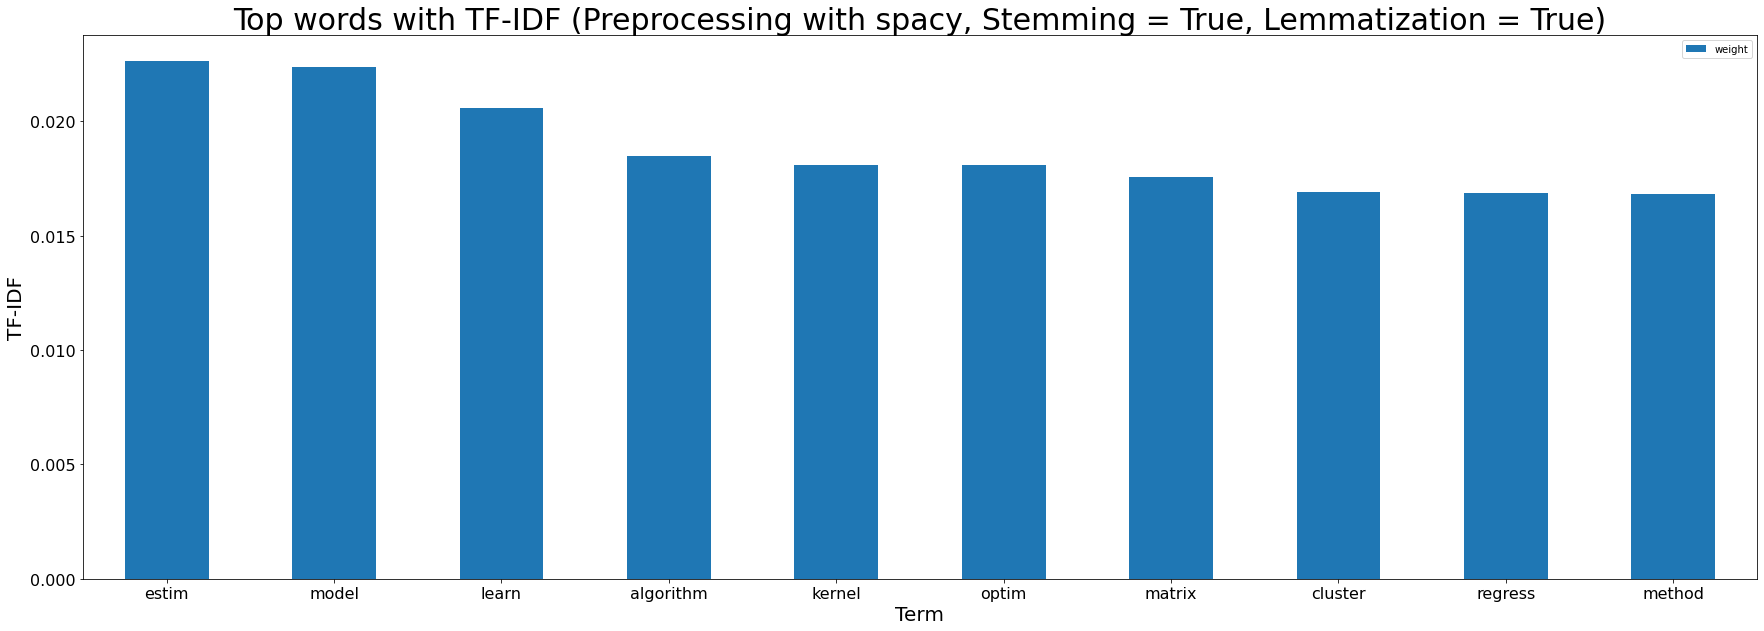

In [144]:
plot_histogram(get_top_words(corpus_tfidf, "weight"), "TF-IDF", "weight")


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


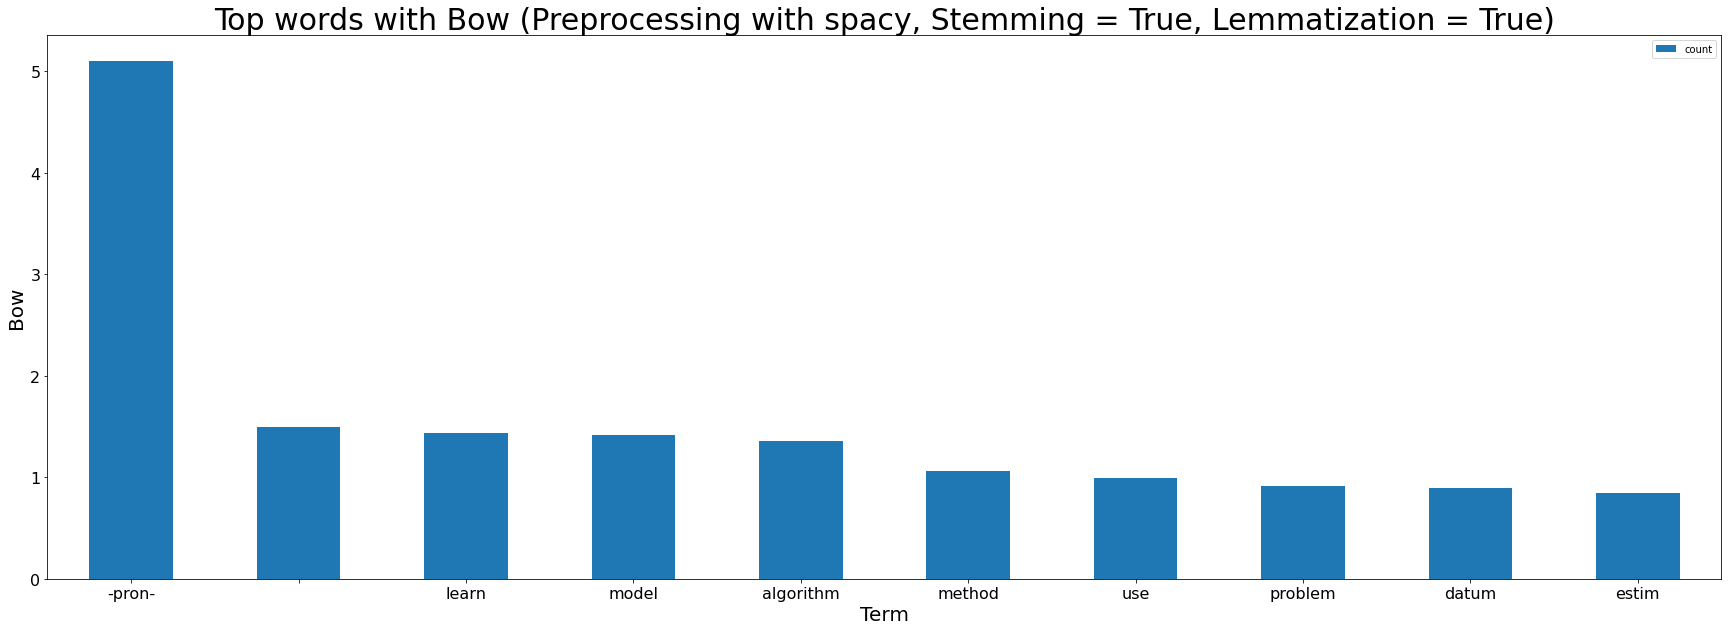

In [145]:
plot_histogram(get_top_words(BoW_corpus, "count"), "Bow", "count")

## Topics

In [17]:
lsi_tfidf.print_topics()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.142*"estim" + 0.128*"model" + 0.115*"kernel" + 0.112*"matrix" + 0.107*"regress" + 0.106*"learn" + 0.104*"optim" + 0.102*"algorithm" + 0.100*"distribut" + 0.100*"method"'),
 (1,
  '-0.298*"graph" + -0.246*"cluster" + -0.234*"causal" + 0.184*"convex" + -0.173*"graphic" + 0.172*"kernel" + 0.158*"gradient" + -0.156*"model" + -0.150*"network" + 0.150*"optim"')]

In [18]:
lsi_bow.print_topics()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.716*"-pron-" + 0.203*"  " + 0.190*"model" + 0.181*"learn" + 0.181*"algorithm" + 0.139*"method" + 0.129*"use" + 0.122*"problem" + 0.116*"datum" + 0.110*"estim"'),
 (1,
  '0.724*"model" + -0.299*"algorithm" + 0.190*"estim" + -0.183*"optim" + -0.161*"problem" + 0.149*"datum" + -0.131*"  " + -0.107*"convex" + 0.104*"infer" + 0.100*"latent"')]

In [19]:
lda_model.print_topics()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.006*"assort" + 0.004*"optim" + 0.003*"model" + 0.003*"estim" + 0.003*"product" + 0.003*"network" + 0.003*"polici" + 0.003*"featur" + 0.003*"chang" + 0.003*"learn"'),
 (1,
  '0.004*"assort" + 0.002*"scikit" + 0.002*"python" + 0.002*"librari" + 0.001*"toolkit" + 0.001*"tslearn" + 0.001*"licens" + 0.001*"mahout" + 0.001*"surviv" + 0.001*"apach"')]

## Plot

In [100]:
def plot_2d_space(corpus, method, use_tsne=False):

  if isinstance(method, models.ldamodel.LdaModel):
    documents_2d_1=[x[0][0][1] for x in method[corpus] if x]
    documents_2d_2=[x[0][1][1] for x in list(method[corpus]) if x]
  else:
    documents_2d_1=[x[0][1] for x in method[corpus] if x]
    documents_2d_2=[x[1][1] for x in list(method[corpus]) if x]


  fig, ax = plt.subplots(figsize=(10,10))

  # Get topic weights
  topic_weights = []
  for i, row_list in enumerate(method[corpus]):
    if row_list:
      if isinstance(method, models.ldamodel.LdaModel):
        topic_weights.append([w for i, w in row_list[0]])
      else:
        topic_weights.append([w for i, w in row_list])

  # Array of topic weights    
  arr = pd.DataFrame(topic_weights).fillna(0).values

  # Dominant topic number in each doc
  topic_num = np.argmax(arr, axis=1)

  if use_tsne:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99)
    tsne = tsne_model.fit_transform(arr)
    documents_2d_1 = tsne[:,0]
    documents_2d_2 = tsne[:,1]

  ax.scatter(documents_2d_1, documents_2d_2, c=topic_num, s=80 ,alpha=0.8)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


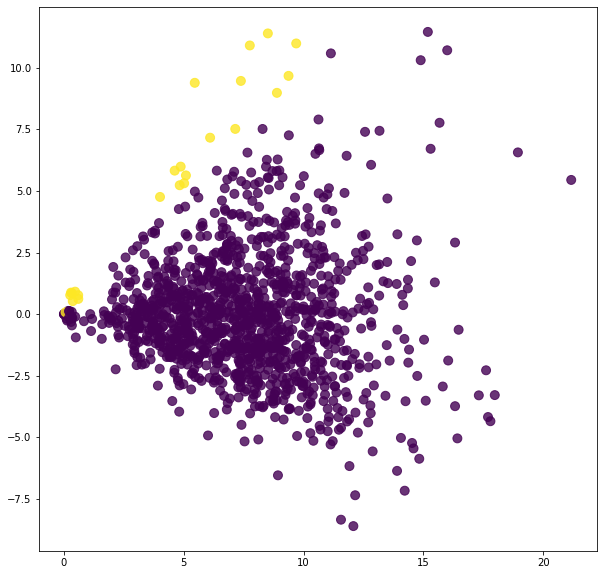

In [101]:
plot_2d_space(BoW_corpus, lsi_bow)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


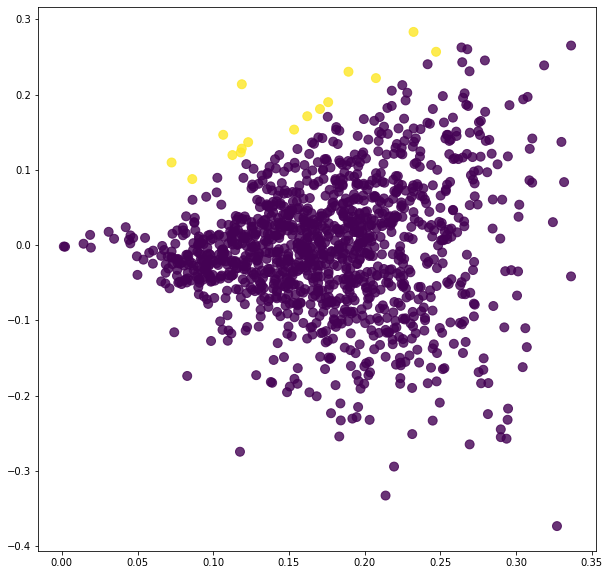

In [102]:
plot_2d_space(corpus_tfidf, lsi_tfidf)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


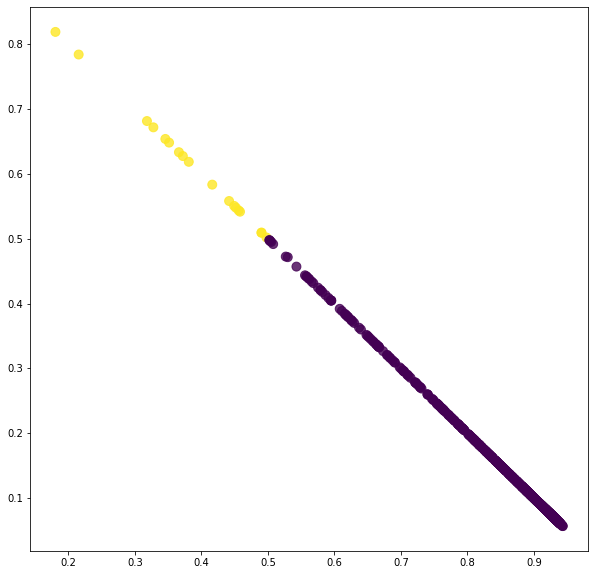

In [103]:
plot_2d_space(corpus_tfidf, lda_model)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1261 samples in 0.001s...
[t-SNE] Computed neighbors for 1261 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1261
[t-SNE] Computed conditional probabilities for sample 1261 / 1261
[t-SNE] Mean sigma: 0.000796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.430382
[t-SNE] KL divergence after 1000 iterations: 0.178379


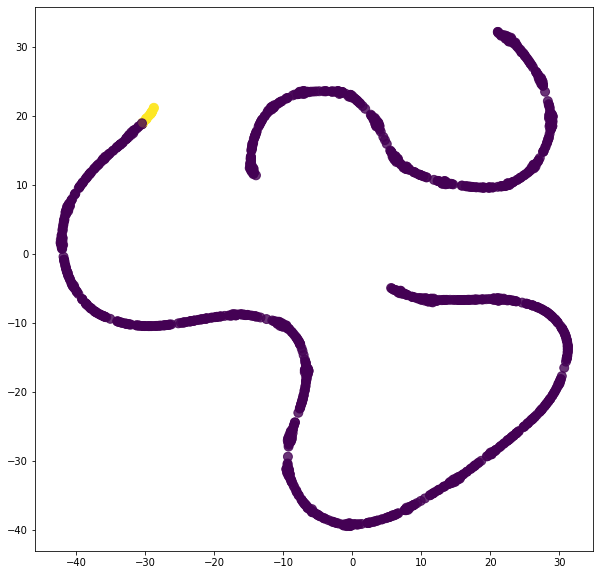

In [104]:
plot_2d_space(corpus_tfidf, lda_model, use_tsne=True)

In [105]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary=lda_model.id2word, mds='mmds')

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
vis

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004022 -0.070985       1        1  88.444011
1      0.004022  0.070985       2        1  11.555989, topic_info=          Term       Freq      Total Category  logprob  loglift
2939    assort  42.000000  42.000000  Default  30.0000  30.0000
801     python   3.000000   3.000000  Default  29.0000  29.0000
3968    scikit   2.000000   2.000000  Default  28.0000  28.0000
798    librari   3.000000   3.000000  Default  27.0000  27.0000
1120   toolkit   1.000000   1.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
4534       mnl   0.753655  12.783067   Topic2  -7.0434  -0.6730
2928    ration   0.545464   3.758072   Topic2  -7.3667   0.2279
5408  inattent   0.468514   2.006381   Topic2  -7.5188   0.7034
5493    season   0.605363   7.061138   Topic2  -7.2625  -0.2986
3028       ucb   0.604520  11.143152   Topic2  -7.2639  -0.7562

[113 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  1.010050           
3330      1  0.835429         ai
3330      2  0.417714         ai
8         1  1.015531  algorithm
2802      1  0.680391      apach
...     ...       ...        ...
5292      1  0.493957    tslearn
5292      2  0.493957    tslearn
3028      1  0.987153        ucb
3028      2  0.089741        ucb
5410      1  0.996819     youtub

[104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])